This notebook is used to run runtime or accuracy comparison experiments.

In [1]:
import numpy as np
import pandas as pd
import arviz as az
import matplotlib.pyplot as plt
plt.rcParams["figure.autolayout"] = True # to for tight_layout()

import itertools
import random
import operator

import os, sys
sys.path.append(os.path.join("../"))

# our library
from src.mcmc_sat import models, mcmc, smt

## Triangle

In [2]:
# Timeout
TIMEOUT = 60*5 # seconds (5min)

(g, num_bits, num_vars) = models.get_triangle_sat()
(s, num_vars) = models.get_triangle_smt()
backends = ['spur', 'cmsgen', 'megasampler']
traces_triangle = [ 
    mcmc.sample_mh_trace_from_z3_model(
        backend=backend,
        z3_problem=g,
        num_bits=num_bits,
        num_vars=num_vars,
        timeout_sampler=TIMEOUT,
        num_samples=10000) 
    if backend in ['spur','cmsgen']
    else mcmc.sample_mh_trace_from_z3_model(
            backend=backend,
            z3_problem=s,
            algo='MeGAb', #  MeGA not working
            timeout_sampler=TIMEOUT,
            reweight_samples=True,
            num_samples=10000)
    for backend in backends ]

Using default filename: "spur_input/samples_z3_problem.txt"
Performing Uniform Model Sampling...
Input File:  spur_input/z3_problem.cnf
Output File: spur_input/samples_z3_problem.txt

Preprocessing ... DONE
variables (all/used/free): 	47/47/0
independent support size:  	0
clauses (all/long/binary/unit): 151/75/69/7
Initialize cache
Size of Cacheable Component:	56
Size of MPZ Class:	16
Maximum cache size:	1206 MB

STAGE #1: Build the initial partial assignments
STAGE #1: COMPLETED building initial partial assignments
STAGE #2 - Filling in partial assignments...
Initialize cache
Size of Cacheable Component:	56
Size of MPZ Class:	16
Maximum cache size:	1206 MB

Sample #1 of 4 is already a complete assignment.  Continuing...
Completing sample #2 of 4 which has 4 variables unset and 1240 samples.
Completing sample #3 of 4 which has 11 variables unset and 1866 samples.
Completing sample #4 of 4 which has 8 variables unset and 1820 samples.
STAGE #2 - COMPLETE


variables (total / active / fr

c CMSGen Copyright Mate Soos (soos.mate@gmail.com)
c CMSGen SHA revision 00791438b32bb387e1f6ba7c1b211d7f6595aa06
c CMSGen is MIT licensed
c CMSGen compilation env CMAKE_CXX_COMPILER = /usr/bin/c++ | CMAKE_CXX_FLAGS =  -fno-stack-protector -mtune=native -Wlogical-op -Wrestrict -Wnull-dereference -Wdouble-promotion -Wshadow -Wformat=2 -Wextra-semi -pedantic | COMPILE_DEFINES =  -DNDEBUG -D_FORTIFY_SOURCE=0 -DUSE_GAUSS -DUSE_ZLIB -DYALSAT_FPU | STATICCOMPILE = ON | ZLIB_FOUND = TRUE | VALGRIND_FOUND =  | ENABLE_TESTING = ON | SLOW_DEBUG = OFF | ENABLE_ASSERTIONS = OFF | MY_TARGETS =  | LARGEMEM =  | LIMITMEM =  | 
c CMSGen compiled with gcc version 9.4.0
c executed with command line: cmsgen --samples 10000 --samplefile cmsgen_input/cmsgen_samples.out cmsgen_input/z3_problem.cnf
c Writing samples to file: cmsgen_input/cmsgen_samples.out
c Number of samples found until now:     10
c Number of samples found until now:     20
c Number of samples found until now:     30
c Number of samples fo

Parsing input file: megasampler_input/z3_problem.smt2
Number of formulas in file: 7
-------------FORMULA STATISTICS-------------
Arrays 0
Bit-vectors 0
Bools 0
Bits 0
Uninterpreted functions 0
Ints 3
Reals 0
Formula tree depth 2
--------------------------------------------
starting MeGASampler
Formula is satisfiable
Termination due to: index out of bounds
---------SOLVING STATISTICS--------
do_epoch time: 0.0367447
epoch time: 0.0660119
grow_seed time: 0.00126812
initial_solving time: 0.0012841
output time: 0.000302244
start_epoch time: 0.0292449
total time: 0.0688904
Epochs: 16
MAX-SMT calls: 1
SMT calls: 17
Assignments considered (with repetitions): 1632
Models (with repetitions): 1632
Unique models (# samples in file): 16
-----------------------------------
Samples have been reweighted. The sampler generated 16 and the reweighting process has generated 10000 (according to the unnormalized posterior probability specified in the input parameter `f`).



megasampler(__cxa_throw+0xd4)[0x60b26d8f541a]
megasampler(+0x166ed)[0x60b26d8f56ed]
megasampler(_ZN7Sampler11start_epochEv+0x10f)[0x60b26d8feb5f]
megasampler(_ZN4MeGA11regular_runERN2z37contextERKNS_4argsE+0x386)[0x60b26d922196]
megasampler(main+0x17d)[0x60b26d8f64bd]
/lib/x86_64-linux-gnu/libc.so.6(+0x29d90)[0x7a8f69629d90]
/lib/x86_64-linux-gnu/libc.so.6(__libc_start_main+0x80)[0x7a8f69629e40]
megasampler(_start+0x25)[0x60b26d8f6575]


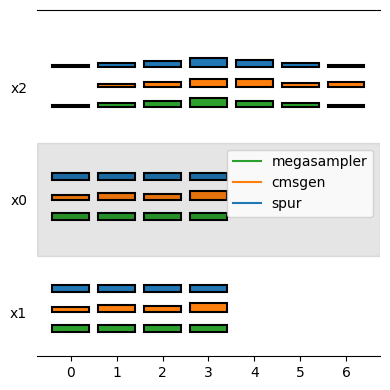

In [3]:
az.plot_forest(traces_triangle, combined=True, model_names=backends, hdi_prob=0.95, kind='ridgeplot', figsize=(4,4), ridgeplot_overlap=0.5);

In [4]:
# Analytical solution
p_x0 = lambda x: 1/4
p_x1 = lambda x: 1/4
p_x0x1 = lambda x: sum([p_x0(i)*p_x1(j) if i+j == x else 0 for i in range(4) for j in range(4)])

### Mean convergence experiments (absolute distance)

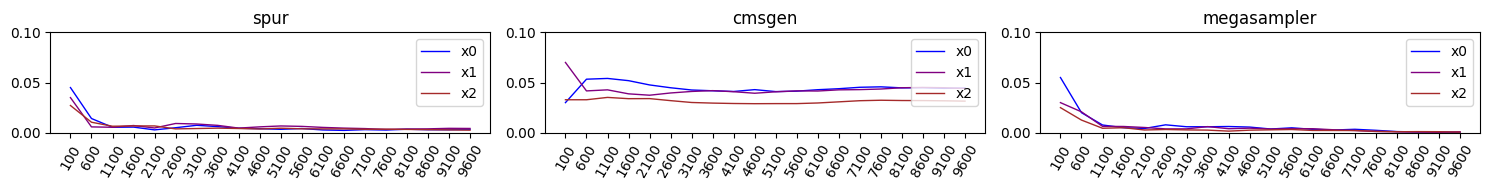

In [29]:
batches = np.arange(100, 10001, step=500)

fig, axs = plt.subplots(1,3,figsize=(15,2))
# fig, ax = plt.subplots(1,figsize=(10,4))

avg_abs_dist = {b: [] for b in backends}

for b,i,ax,ls in zip(backends,range(3),axs,['-','-','-']):
# for b,i,ls in zip(backends,range(3),['--','-.',':']):
    for (f,x,c) in zip([p_x0, p_x1, p_x0x1],['x0','x1','x2'],['blue','purple','brown']):
        res = []
        for batch in batches:
            toi = traces_triangle[i].posterior.sel(chain=0,draw=np.arange(batch))[x]
            est_freqs = np.unique(toi, return_counts=True)[1]/batch
            abs_dist = [np.abs(f(i) - ef) for (i,ef) in zip(np.arange(len(est_freqs)),est_freqs)]
            res.append(sum(abs_dist)/len(abs_dist))
            # print(x,b,batch,abs_dist,res) # debug
        ax.plot(res, color=c, label=x, ls=ls, lw=1)
        avg_abs_dist[b].append(res[-1:][0])
    # ax.hlines(y=0.0, xmin=0.0, xmax=20.0, ls='--', color='k', lw=1)
    ax.set_xticks(np.arange(len(batches)),batches,rotation=60)
    ax.set_title(b)
    ax.set_ylim(ymin=0.0, ymax=0.1)
    ax.legend()
plt.show();

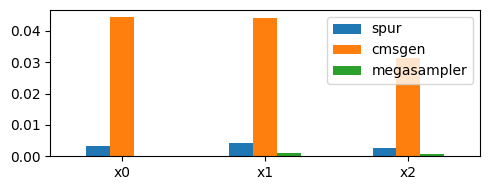

In [35]:
df = pd.DataFrame(avg_abs_dist)
ax = df.plot.bar(figsize=(5,2))
ax.set_xticks(np.arange(3), ['x0','x1','x2'], rotation=0);

## DB CACM

In [221]:
TIMEOUT = 60*10 # seconds (10min)

(g, num_bits, num_vars) = models.get_db_cacm_sat()
(s, num_vars) = models.get_db_cacm_smt()
backends = ['spur', 'cmsgen', 'megasampler']
traces_db_cacm = [ 
    mcmc.sample_mh_trace_from_z3_model(backend=backend,
                                       z3_problem=g,
                                       num_bits=num_bits,
                                       num_vars=num_vars,
                                       timeout_sampler=TIMEOUT,
                                       num_samples=5000)
    if backend in ['spur','cmsgen']
    else mcmc.sample_mh_trace_from_z3_model(
            backend=backend,
            z3_problem=s,
            timeout_sampler=TIMEOUT,
            reweight_samples=True,
            num_samples=5000)
    for backend in backends ]

Using default filename: "spur_input/samples_z3_problem.txt"
Performing Uniform Model Sampling...
Input File:  spur_input/z3_problem.cnf
Output File: spur_input/samples_z3_problem.txt

Preprocessing ... DONE
variables (all/used/free): 	1584/1584/0
independent support size:  	0
clauses (all/long/binary/unit): 7444/5927/1458/59
Initialize cache
Size of Cacheable Component:	56
Size of MPZ Class:	16
Maximum cache size:	2606 MB

STAGE #1: Build the initial partial assignments


STAGE #1: COMPLETED building initial partial assignments
STAGE #2 - Filling in partial assignments...
Initialize cache
Size of Cacheable Component:	56
Size of MPZ Class:	16
Maximum cache size:	2606 MB

Sample #1 of 127 is already a complete assignment.  Continuing...
Completing sample #2 of 127 which has 60 variables unset and 3 samples.
Completing sample #3 of 127 which has 37 variables unset and 29 samples.
Completing sample #4 of 127 which has 33 variables unset and 35 samples.
Completing sample #5 of 127 which has 56 variables unset and 19 samples.
Completing sample #6 of 127 which has 38 variables unset and 7 samples.
Completing sample #7 of 127 which has 36 variables unset and 5 samples.
Completing sample #8 of 127 which has 33 variables unset and 15 samples.
Completing sample #9 of 127 which has 135 variables unset and 24 samples.
Completing sample #10 of 127 which has 55 variables unset and 25 samples.
Completing sample #11 of 127 which has 147 variables unset and 17 samples.
C

Completing sample #40 of 127 which has 77 variables unset and 5 samples.
Completing sample #41 of 127 which has 85 variables unset and 4 samples.
Completing sample #42 of 127 which has 80 variables unset and 10 samples.
Completing sample #43 of 127 which has 61 variables unset and 23 samples.
Completing sample #44 of 127 which has 18 variables unset and 6 samples.
Completing sample #45 of 127 which has 28 variables unset and 11 samples.
Completing sample #46 of 127 which has 61 variables unset and 20 samples.
Completing sample #47 of 127 which has 76 variables unset and 17 samples.
Completing sample #48 of 127 which has 39 variables unset and 5 samples.
Completing sample #49 of 127 which has 39 variables unset and 4 samples.
Completing sample #50 of 127 which has 29 variables unset and 3 samples.
Completing sample #51 of 127 which has 31 variables unset and 6 samples.
Completing sample #52 of 127 which has 13 variables unset and 11 samples.
Completing sample #53 of 127 which has 13 var

Completing sample #82 of 127 which has 53 variables unset and 6 samples.
Completing sample #83 of 127 which has 55 variables unset and 4 samples.
Completing sample #84 of 127 which has 28 variables unset and 63 samples.
Completing sample #85 of 127 which has 50 variables unset and 3 samples.
Completing sample #86 of 127 which has 71 variables unset and 12 samples.
Completing sample #87 of 127 which has 52 variables unset and 6 samples.
Completing sample #88 of 127 which has 84 variables unset and 5 samples.
Completing sample #89 of 127 which has 55 variables unset and 5 samples.
Completing sample #90 of 127 which has 44 variables unset and 5 samples.
Completing sample #91 of 127 which has 58 variables unset and 6 samples.
Completing sample #92 of 127 which has 40 variables unset and 7 samples.
Completing sample #93 of 127 which has 48 variables unset and 5 samples.
Completing sample #94 of 127 which has 31 variables unset and 5 samples.
Completing sample #95 of 127 which has 21 variabl

Completing sample #121 of 127 which has 66 variables unset and 9 samples.
Completing sample #122 of 127 which has 82 variables unset and 8 samples.
Completing sample #123 of 127 which has 80 variables unset and 8 samples.
Completing sample #124 of 127 which has 84 variables unset and 12 samples.
Completing sample #125 of 127 which has 34 variables unset and 4 samples.
Completing sample #126 of 127 which has 86 variables unset and 14 samples.
Completing sample #127 of 127 which has 63 variables unset and 29 samples.
STAGE #2 - COMPLETE


variables (total / active / free)	1584/1584/0
clauses (removed) 		7444 (18446744073709551614)
decisions 				2020
conflicts 				469
conflict clauses (all/bin/unit) 	3852/110/61
failed literals found by implicit BCP 	 2292
implicit BCP miss rate 	98.1686%
bytes cache size     	21079724	
bytes cache (overall) 	21378632
bytes cache (infra / comps) 20234408/845316	
bytes pure comp data (curr)    735380
bytes pure comp data (overall) 1017264
bytes cache with 

c CMSGen Copyright Mate Soos (soos.mate@gmail.com)
c CMSGen SHA revision 00791438b32bb387e1f6ba7c1b211d7f6595aa06
c CMSGen is MIT licensed
c CMSGen compilation env CMAKE_CXX_COMPILER = /usr/bin/c++ | CMAKE_CXX_FLAGS =  -fno-stack-protector -mtune=native -Wlogical-op -Wrestrict -Wnull-dereference -Wdouble-promotion -Wshadow -Wformat=2 -Wextra-semi -pedantic | COMPILE_DEFINES =  -DNDEBUG -D_FORTIFY_SOURCE=0 -DUSE_GAUSS -DUSE_ZLIB -DYALSAT_FPU | STATICCOMPILE = ON | ZLIB_FOUND = TRUE | VALGRIND_FOUND =  | ENABLE_TESTING = ON | SLOW_DEBUG = OFF | ENABLE_ASSERTIONS = OFF | MY_TARGETS =  | LARGEMEM =  | LIMITMEM =  | 
c CMSGen compiled with gcc version 9.4.0
c executed with command line: cmsgen --samples 5000 --samplefile cmsgen_input/cmsgen_samples.out cmsgen_input/z3_problem.cnf
c Writing samples to file: cmsgen_input/cmsgen_samples.out
c Number of samples found until now:     10
c Number of samples found until now:     20
c Number of samples found until now:     30
c Number of samples fou

c Number of samples found until now:    130
c Number of samples found until now:    140
c Number of samples found until now:    150
c Number of samples found until now:    160
c Number of samples found until now:    170
c Number of samples found until now:    180
c Number of samples found until now:    190
c Number of samples found until now:    200
c Number of samples found until now:    210
c Number of samples found until now:    220
c Number of samples found until now:    230
c Number of samples found until now:    240


c Number of samples found until now:    250
c Number of samples found until now:    260
c Number of samples found until now:    270
c Number of samples found until now:    280
c Number of samples found until now:    290
c Number of samples found until now:    300
c Number of samples found until now:    310
c Number of samples found until now:    320
c Number of samples found until now:    330
c Number of samples found until now:    340
c Number of samples found until now:    350
c Number of samples found until now:    360
c Number of samples found until now:    370
c Number of samples found until now:    380
c Number of samples found until now:    390
c Number of samples found until now:    400
c Number of samples found until now:    410
c Number of samples found until now:    420
c Number of samples found until now:    430
c Number of samples found until now:    440
c Number of samples found until now:    450
c Number of samples found until now:    460
c Number of samples found until 

c Number of samples found until now:    520
c Number of samples found until now:    530
c Number of samples found until now:    540
c Number of samples found until now:    550
c Number of samples found until now:    560
c Number of samples found until now:    570
c Number of samples found until now:    580
c Number of samples found until now:    590
c Number of samples found until now:    600
c Number of samples found until now:    610
c Number of samples found until now:    620
c Number of samples found until now:    630
c Number of samples found until now:    640
c Number of samples found until now:    650
c Number of samples found until now:    660
c Number of samples found until now:    670
c Number of samples found until now:    680
c Number of samples found until now:    690
c Number of samples found until now:    700
c Number of samples found until now:    710
c Number of samples found until now:    720
c Number of samples found until now:    730
c Number of samples found until 

c Number of samples found until now:    780
c Number of samples found until now:    790
c Number of samples found until now:    800
c Number of samples found until now:    810
c Number of samples found until now:    820
c Number of samples found until now:    830
c Number of samples found until now:    840
c Number of samples found until now:    850
c Number of samples found until now:    860
c Number of samples found until now:    870
c Number of samples found until now:    880
c Number of samples found until now:    890
c Number of samples found until now:    900
c Number of samples found until now:    910
c Number of samples found until now:    920
c Number of samples found until now:    930
c Number of samples found until now:    940
c Number of samples found until now:    950
c Number of samples found until now:    960
c Number of samples found until now:    970
c Number of samples found until now:    980
c Number of samples found until now:    990
c Number of samples found until 

c Number of samples found until now:   1020
c Number of samples found until now:   1030
c Number of samples found until now:   1040
c Number of samples found until now:   1050
c Number of samples found until now:   1060
c Number of samples found until now:   1070
c Number of samples found until now:   1080
c Number of samples found until now:   1090
c Number of samples found until now:   1100
c Number of samples found until now:   1110
c Number of samples found until now:   1120
c Number of samples found until now:   1130
c Number of samples found until now:   1140
c Number of samples found until now:   1150
c Number of samples found until now:   1160
c Number of samples found until now:   1170
c Number of samples found until now:   1180
c Number of samples found until now:   1190
c Number of samples found until now:   1200
c Number of samples found until now:   1210
c Number of samples found until now:   1220
c Number of samples found until now:   1230
c Number of samples found until 

c Number of samples found until now:   1330
c Number of samples found until now:   1340
c Number of samples found until now:   1350
c Number of samples found until now:   1360
c Number of samples found until now:   1370
c Number of samples found until now:   1380
c Number of samples found until now:   1390
c Number of samples found until now:   1400
c Number of samples found until now:   1410
c Number of samples found until now:   1420
c Number of samples found until now:   1430
c Number of samples found until now:   1440
c Number of samples found until now:   1450
c Number of samples found until now:   1460
c Number of samples found until now:   1470
c Number of samples found until now:   1480
c Number of samples found until now:   1490
c Number of samples found until now:   1500
c Number of samples found until now:   1510
c Number of samples found until now:   1520
c Number of samples found until now:   1530
c Number of samples found until now:   1540
c Number of samples found until 

c Number of samples found until now:   1680
c Number of samples found until now:   1690
c Number of samples found until now:   1700
c Number of samples found until now:   1710
c Number of samples found until now:   1720
c Number of samples found until now:   1730
c Number of samples found until now:   1740
c Number of samples found until now:   1750
c Number of samples found until now:   1760
c Number of samples found until now:   1770
c Number of samples found until now:   1780
c Number of samples found until now:   1790
c Number of samples found until now:   1800
c Number of samples found until now:   1810
c Number of samples found until now:   1820
c Number of samples found until now:   1830
c Number of samples found until now:   1840
c Number of samples found until now:   1850
c Number of samples found until now:   1860
c Number of samples found until now:   1870
c Number of samples found until now:   1880
c Number of samples found until now:   1890
c Number of samples found until 

c Number of samples found until now:   2010
c Number of samples found until now:   2020
c Number of samples found until now:   2030
c Number of samples found until now:   2040
c Number of samples found until now:   2050
c Number of samples found until now:   2060
c Number of samples found until now:   2070
c Number of samples found until now:   2080
c Number of samples found until now:   2090
c Number of samples found until now:   2100
c Number of samples found until now:   2110
c Number of samples found until now:   2120
c Number of samples found until now:   2130
c Number of samples found until now:   2140
c Number of samples found until now:   2150
c Number of samples found until now:   2160
c Number of samples found until now:   2170
c Number of samples found until now:   2180
c Number of samples found until now:   2190
c Number of samples found until now:   2200
c Number of samples found until now:   2210
c Number of samples found until now:   2220
c Number of samples found until 

c Number of samples found until now:   2340
c Number of samples found until now:   2350
c Number of samples found until now:   2360
c Number of samples found until now:   2370
c Number of samples found until now:   2380
c Number of samples found until now:   2390
c Number of samples found until now:   2400
c Number of samples found until now:   2410
c Number of samples found until now:   2420
c Number of samples found until now:   2430
c Number of samples found until now:   2440
c Number of samples found until now:   2450
c Number of samples found until now:   2460
c Number of samples found until now:   2470
c Number of samples found until now:   2480
c Number of samples found until now:   2490
c Number of samples found until now:   2500
c Number of samples found until now:   2510
c Number of samples found until now:   2520
c Number of samples found until now:   2530
c Number of samples found until now:   2540
c Number of samples found until now:   2550
c Number of samples found until 

c Number of samples found until now:   2680
c Number of samples found until now:   2690
c Number of samples found until now:   2700
c Number of samples found until now:   2710
c Number of samples found until now:   2720
c Number of samples found until now:   2730
c Number of samples found until now:   2740
c Number of samples found until now:   2750
c Number of samples found until now:   2760
c Number of samples found until now:   2770
c Number of samples found until now:   2780
c Number of samples found until now:   2790
c Number of samples found until now:   2800
c Number of samples found until now:   2810
c Number of samples found until now:   2820
c Number of samples found until now:   2830
c Number of samples found until now:   2840
c Number of samples found until now:   2850
c Number of samples found until now:   2860
c Number of samples found until now:   2870
c Number of samples found until now:   2880
c Number of samples found until now:   2890
c Number of samples found until 

c Number of samples found until now:   3030
c Number of samples found until now:   3040
c Number of samples found until now:   3050
c Number of samples found until now:   3060
c Number of samples found until now:   3070
c Number of samples found until now:   3080
c Number of samples found until now:   3090
c Number of samples found until now:   3100
c Number of samples found until now:   3110
c Number of samples found until now:   3120
c Number of samples found until now:   3130
c Number of samples found until now:   3140
c Number of samples found until now:   3150
c Number of samples found until now:   3160
c Number of samples found until now:   3170
c Number of samples found until now:   3180
c Number of samples found until now:   3190
c Number of samples found until now:   3200
c Number of samples found until now:   3210
c Number of samples found until now:   3220
c Number of samples found until now:   3230
c Number of samples found until now:   3240
c Number of samples found until 

c Number of samples found until now:   3430
c Number of samples found until now:   3440
c Number of samples found until now:   3450
c Number of samples found until now:   3460
c Number of samples found until now:   3470
c Number of samples found until now:   3480
c Number of samples found until now:   3490
c Number of samples found until now:   3500
c Number of samples found until now:   3510
c Number of samples found until now:   3520
c Number of samples found until now:   3530
c Number of samples found until now:   3540
c Number of samples found until now:   3550
c Number of samples found until now:   3560
c Number of samples found until now:   3570
c Number of samples found until now:   3580
c Number of samples found until now:   3590
c Number of samples found until now:   3600
c Number of samples found until now:   3610
c Number of samples found until now:   3620
c Number of samples found until now:   3630
c Number of samples found until now:   3640
c Number of samples found until 

c Number of samples found until now:   3810
c Number of samples found until now:   3820
c Number of samples found until now:   3830
c Number of samples found until now:   3840
c Number of samples found until now:   3850
c Number of samples found until now:   3860
c Number of samples found until now:   3870
c Number of samples found until now:   3880
c Number of samples found until now:   3890
c Number of samples found until now:   3900
c Number of samples found until now:   3910
c Number of samples found until now:   3920
c Number of samples found until now:   3930
c Number of samples found until now:   3940
c Number of samples found until now:   3950
c Number of samples found until now:   3960
c Number of samples found until now:   3970
c Number of samples found until now:   3980
c Number of samples found until now:   3990
c Number of samples found until now:   4000
c Number of samples found until now:   4010
c Number of samples found until now:   4020
c Number of samples found until 

c Number of samples found until now:   4190
c Number of samples found until now:   4200
c Number of samples found until now:   4210
c Number of samples found until now:   4220
c Number of samples found until now:   4230
c Number of samples found until now:   4240
c Number of samples found until now:   4250
c Number of samples found until now:   4260
c Number of samples found until now:   4270
c Number of samples found until now:   4280
c Number of samples found until now:   4290
c Number of samples found until now:   4300
c Number of samples found until now:   4310
c Number of samples found until now:   4320
c Number of samples found until now:   4330
c Number of samples found until now:   4340
c Number of samples found until now:   4350
c Number of samples found until now:   4360
c Number of samples found until now:   4370
c Number of samples found until now:   4380
c Number of samples found until now:   4390
c Number of samples found until now:   4400
c Number of samples found until 

c Number of samples found until now:   4560
c Number of samples found until now:   4570
c Number of samples found until now:   4580
c Number of samples found until now:   4590
c Number of samples found until now:   4600
c Number of samples found until now:   4610
c Number of samples found until now:   4620
c Number of samples found until now:   4630
c Number of samples found until now:   4640
c Number of samples found until now:   4650
c Number of samples found until now:   4660
c Number of samples found until now:   4670
c Number of samples found until now:   4680
c Number of samples found until now:   4690
c Number of samples found until now:   4700
c Number of samples found until now:   4710
c Number of samples found until now:   4720
c Number of samples found until now:   4730
c Number of samples found until now:   4740
c Number of samples found until now:   4750
c Number of samples found until now:   4760
c Number of samples found until now:   4770
c Number of samples found until 

c Number of samples found until now:   4920
c Number of samples found until now:   4930
c Number of samples found until now:   4940
c Number of samples found until now:   4950
c Number of samples found until now:   4960
c Number of samples found until now:   4970
c Number of samples found until now:   4980
c Number of samples found until now:   4990
c Finished generating all 5000 samples
c Total time: 3.4 s 


Parsing input file: megasampler_input/z3_problem.smt2
Number of formulas in file: 20
-------------FORMULA STATISTICS-------------
Arrays 0
Bit-vectors 0
Bools 0
Bits 0
Uninterpreted functions 0
Ints 10
Reals 0
Formula tree depth 6
--------------------------------------------
starting MeGASampler


Formula is satisfiable
MAX-SMT returned 'unknown' (timeout?)
Stopping: timeout
---------SOLVING STATISTICS--------
do_epoch time: 413.211
epoch time: 599.932
grow_seed time: 19.2606
initial_solving time: 0.0225895
output time: 1.08515
start_epoch time: 186.649
total time: 600.007
Epochs: 49445
MAX-SMT calls: 49446
SMT calls: 1
Assignments considered (with repetitions): 5043289
Models (with repetitions): 5043288
Unique models (# samples in file): 426
-----------------------------------
Samples have been reweighted. The sampler generated 426 and the reweighting process has generated 4686 (according to the unnormalized posterior probability specified in the input parameter `f`).



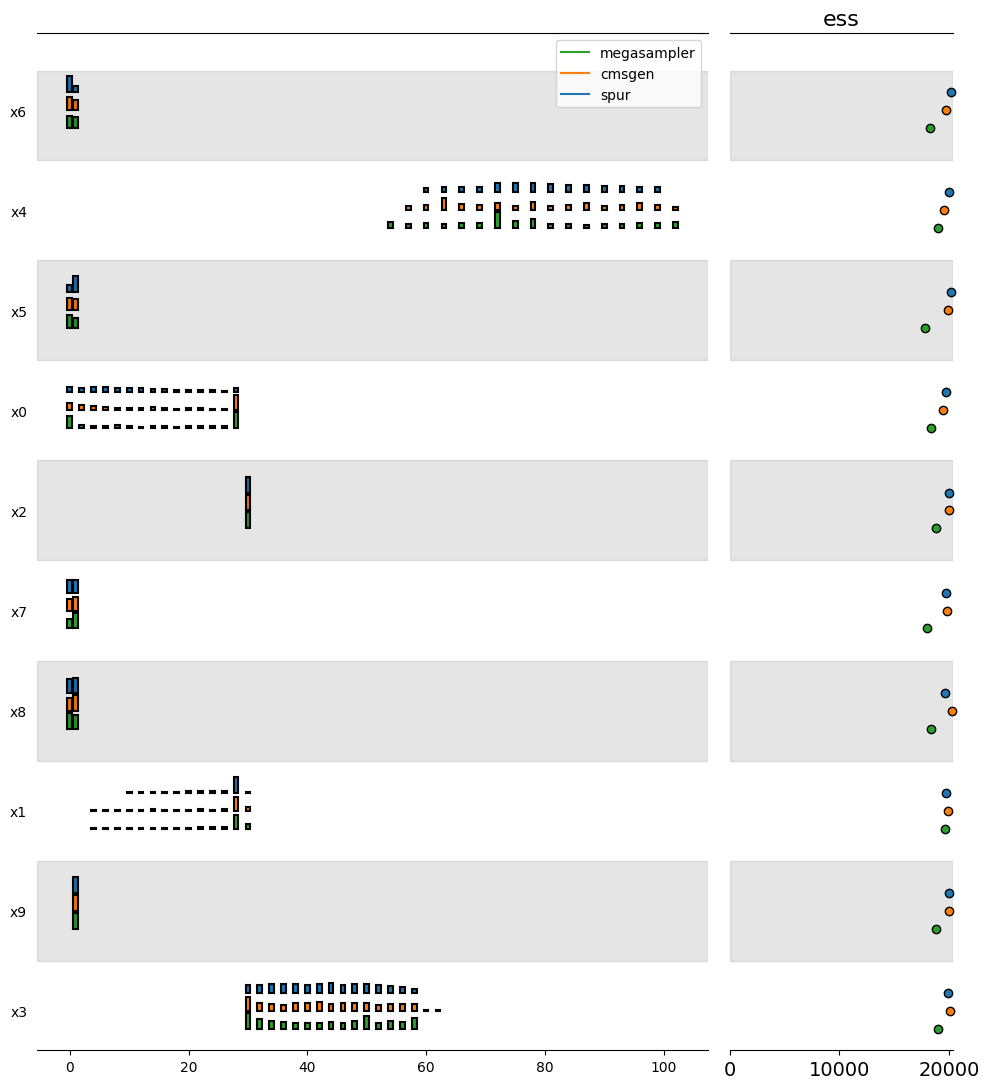

In [222]:
az.plot_forest(traces_db_cacm, combined=True, model_names=backends, hdi_prob=0.95, 
               kind='ridgeplot', figsize=(10,11), ridgeplot_overlap=1, ess=True);

## Mean convergence experiments (absolute distance)

In [223]:
## Analytical (brute force) solution to db_cacm

### list all ages with required median and average age
avg_sat = [ (x0,x1,30,x3,x4) 
            for x0 in range(31) 
            for x1 in range(31) 
            for x3 in range(30,126) 
            for x4 in range(30,126) 
            if x0+x1+30+x3+x4 == 38*5 and
               x0 <= x1 <= 30 <= x3 <= x4]

### list all genders with exactly 3 males
g_sat = [ (g0,g1,g2,g3,g4) 
          for g0 in range(2) 
          for g1 in range(2) 
          for g2 in range(2) 
          for g3 in range(2) 
          for g4 in range(2) 
          if g0+g1+g2+g3+g4 == 3]

### keep only entries with the required average for males
sat_models = [((x0,x1,x2,x3,x4), (g0,g1,g2,g3,g4))
              for (x0,x1,x2,x3,x4) in avg_sat 
              for (g0,g1,g2,g3,g4) in g_sat 
              if x0*g0 + x1*g1 + x2*g2 + x3*g3 + x4*g4 == 44*3
]

### prior on each variable type
p_x01 = lambda x: 1/31
p_x2 = lambda x: 1
p_x34 = lambda x: 1/96
p_g = lambda x: 1/2

### compute unnormalized posterior probabilities
### all variables are independent therefore it is the product
unnormalized_probs = np.array([p_x01(x0) * p_x01(x1) * p_x2(x2) * p_x34(x3) * p_x34(x4) * p_g(g0) * p_g(g1) * p_g(g2) * p_g(g3) * p_g(g4)
                               for (x0,x1,x2,x3,x4) in avg_sat 
                               for (g0,g1,g2,g3,g4) in g_sat 
                               if x0*g0 + x1*g1 + x2*g2 + x3*g3 + x4*g4 == 44*3
])

### compute total probability mass (normalizing factor)
total_prob = sum(unnormalized_probs)

### normalized probabilities
normalized_probs = unnormalized_probs/total_prob

### We put everything in a dataframe to easily make queries
d = {
    'x0': [], 'x1': [], 'x2': [], 'x3': [], 'x4': [], 
    'g0': [], 'g1': [], 'g2': [], 'g3': [], 'g4': [], 
    'p' : []
}

for (((x0,x1,x2,x3,x4), (g0,g1,g2,g3,g4)), p) in zip(sat_models,normalized_probs):
    d['x0'].append(x0)
    d['x1'].append(x1)
    d['x2'].append(x2)
    d['x3'].append(x3)
    d['x4'].append(x4)
    d['g0'].append(g0)
    d['g1'].append(g1)
    d['g2'].append(g2)
    d['g3'].append(g3)
    d['g4'].append(g4)
    d['p'].append(p)

df = pd.DataFrame(d)

### function to query exact solution probability for each variable and outcome
p_var = lambda x,i: df[df[x] == i].p.sum()

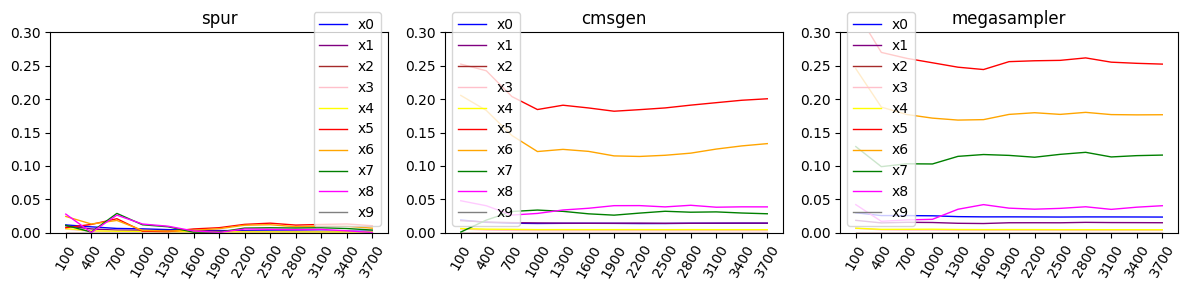

In [226]:
### Plot absolute distance for all variables (averaged on outcomes)
### for an increasing number of samples

batches = np.arange(100, 4000, step=300)

fig, axs = plt.subplots(1,3,figsize=(12,3))
# fig, ax = plt.subplots(1,figsize=(10,4))

avg_abs_dist = {b: [] for b in backends}

for b,i,ax in zip(backends,range(3),axs):
    for (x,c) in zip(
        ['x0','x1','x2','x3','x4','x5','x6','x7','x8','x9'],
        ['blue','purple','brown','pink','yellow','red','orange','green','magenta','gray']):
        res = []
        for batch in batches:
            # function to easily query the estimated mean for a variable and outcome
            def p_est(var, outcome, batch, i):
                toi = traces_db_cacm[i].posterior.sel(chain=0,draw=np.arange(batch))[var]
                return np.mean(toi == outcome).item()

            ## ranges are variable specific for DB cacm
            ran = range(30,31)
            if x in ['x0','x1']:
                ran = range(31)
            elif x in ['x3','x4']:
                ran = range(30,126)
            elif x in ['x5','x6','x7','x8','x9']:
                ran = range(2)                

            x_conv = x if x in ['x0','x1','x2','x3','x4'] else 'g'+str((int(x[1])-5))

            abs_dist = [np.abs(p_var(x_conv,o) - p_est(x,o,batch,i)) for o in ran]
            res.append(sum(abs_dist)/len(abs_dist))
            # print(x,b,batch,abs_dist,res) # debug
        ax.plot(res, color=c, label=x, lw=1)
        avg_abs_dist[b].append(res[-1:][0])
    ax.set_xticks(np.arange(len(batches)),batches,rotation=60)
    ax.set_title(b)
    ax.set_ylim(ymin=0.0, ymax=0.3)
    ax.legend()
plt.show();

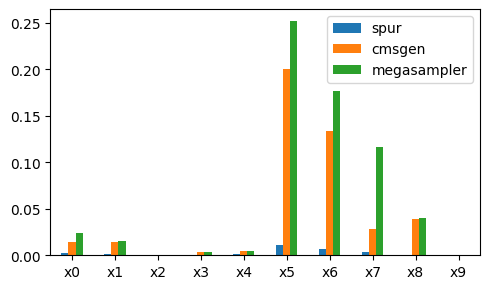

In [227]:
### Plot the absolute distance for the average mean over all outcomes
### for the largest number of samples
df1 = pd.DataFrame(avg_abs_dist)
ax  = df1.plot.bar(figsize=(5,3))
ax.set_xticks(np.arange(10), ['x0','x1','x2','x3','x4','x5','x6','x7','x8','x9'], rotation=0);

## NZ Stats

In [74]:
(g, num_bits, num_vars) = models.get_nz_stats_sat(
    path_to_dataset='sat/spur/nz_db/south_head.csv'
)
(s, num_vars) = models.get_nz_stats_smt(
    path_to_dataset='sat/spur/nz_db/south_head.csv'
)
backends = ['spur', 'cmsgen', 'megasampler']
traces_nz_stats = [ 
    mcmc.sample_mh_trace_from_z3_model(backend=backend,
                                       z3_problem=g,
                                       num_bits=num_bits,
                                       num_vars=num_vars,
                                       num_samples=1000)
    if backend in ['spur','cmsgen']
    else mcmc.sample_mh_trace_from_z3_model(
            backend=backend,
            z3_problem=s,
            num_samples=1000)
    for backend in backends ]

Using default filename: "spur_input/samples_z3_problem.txt"
Performing Uniform Model Sampling...
Input File:  spur_input/z3_problem.cnf
Output File: spur_input/samples_z3_problem.txt

Preprocessing ... DONE
variables (all/used/free): 	661/661/0
independent support size:  	0
clauses (all/long/binary/unit): 2025/1183/754/88
Initialize cache
Size of Cacheable Component:	56
Size of MPZ Class:	16
Maximum cache size:	5264 MB

STAGE #1: Build the initial partial assignments
STAGE #1: COMPLETED building initial partial assignments
STAGE #2 - Filling in partial assignments...
Initialize cache
Size of Cacheable Component:	56
Size of MPZ Class:	16
Maximum cache size:	5264 MB

Completing sample #1 of 2 which has 3 variables unset and 118 samples.
Sample #2 of 2 is already a complete assignment.  Continuing...
STAGE #2 - COMPLETE


variables (total / active / free)	661/661/0
clauses (removed) 		2025 (0)
decisions 				188
conflicts 				1
conflict clauses (all/bin/unit) 	28/17/88
failed literals foun

c CMSGen Copyright Mate Soos (soos.mate@gmail.com)
c CMSGen SHA revision 00791438b32bb387e1f6ba7c1b211d7f6595aa06
c CMSGen is MIT licensed
c CMSGen compilation env CMAKE_CXX_COMPILER = /usr/bin/c++ | CMAKE_CXX_FLAGS =  -fno-stack-protector -mtune=native -Wlogical-op -Wrestrict -Wnull-dereference -Wdouble-promotion -Wshadow -Wformat=2 -Wextra-semi -pedantic | COMPILE_DEFINES =  -DNDEBUG -D_FORTIFY_SOURCE=0 -DUSE_GAUSS -DUSE_ZLIB -DYALSAT_FPU | STATICCOMPILE = ON | ZLIB_FOUND = TRUE | VALGRIND_FOUND =  | ENABLE_TESTING = ON | SLOW_DEBUG = OFF | ENABLE_ASSERTIONS = OFF | MY_TARGETS =  | LARGEMEM =  | LIMITMEM =  | 
c CMSGen compiled with gcc version 9.4.0
c executed with command line: cmsgen --samples 1000 --samplefile cmsgen_input/cmsgen_samples.out cmsgen_input/z3_problem.cnf
c Writing samples to file: cmsgen_input/cmsgen_samples.out
c Number of samples found until now:     10
c Number of samples found until now:     20
c Number of samples found until now:     30
c Number of samples fou

Parsing input file: megasampler_input/z3_problem.smt2
Number of formulas in file: 131
-------------FORMULA STATISTICS-------------
Arrays 0
Bit-vectors 0
Bools 0
Bits 0
Uninterpreted functions 0
Ints 38
Reals 0
Formula tree depth 2
--------------------------------------------
starting MeGASampler


Formula is satisfiable
---------SOLVING STATISTICS--------
do_epoch time: 0.20306
epoch time: 0.207996
grow_seed time: 0.00231367
initial_solving time: 0.014171
output time: 0.00137728
start_epoch time: 0.00957613
total time: 0.311505
Epochs: 2
MAX-SMT calls: 3
SMT calls: 0
Assignments considered (with repetitions): 1000
Models (with repetitions): 1000
Unique models (# samples in file): 1000
-----------------------------------


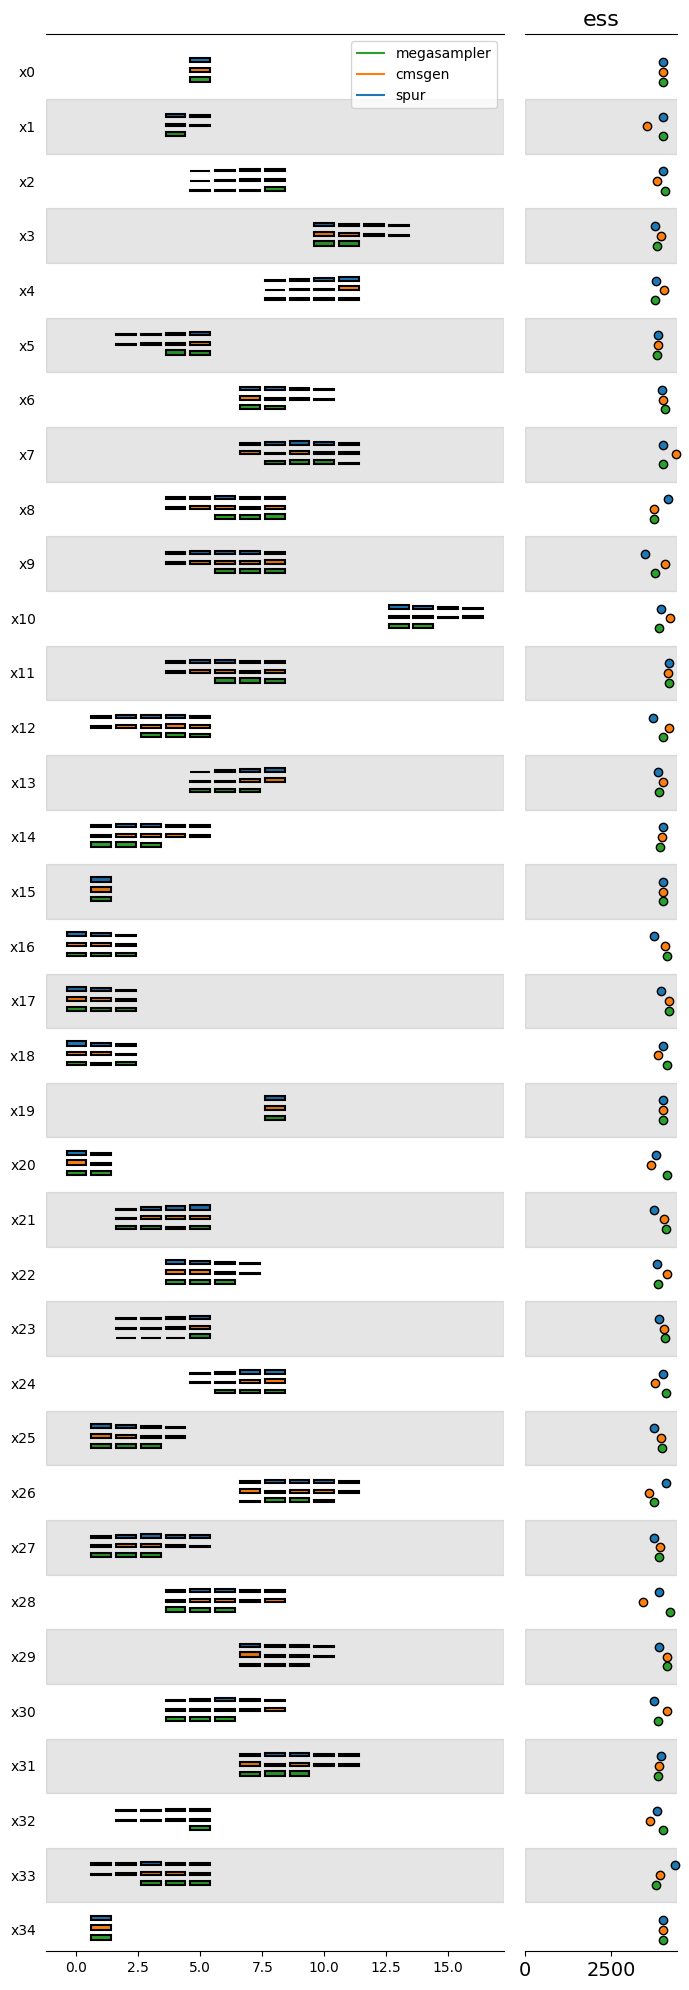

In [75]:
az.plot_forest(traces_nz_stats, var_names=[f'x{i}' for i in range(35)], 
               combined=True, model_names=backends, hdi_prob=0.95, 
               kind='ridgeplot', figsize=(7,20), ridgeplot_overlap=0.5, 
               ess=True);

### Convergence analysis

In [76]:
path_to_dataset = 'sat/spur/nz_db/south_head.csv'
south_head = pd.read_csv(path_to_dataset)
numpy_data = south_head.to_numpy()[:, 1:]

In [77]:
numpy_data

array([[3, 6, 6, 12, 9, 3, 9, 9, 6, 6, 15, 6, 3, 6, 3, 3, 0, 0, 0],
       [6, 0, 3, 6, 3, 6, 3, 9, 3, 6, 9, 6, 9, 3, 3, 3, 0, 0, 0],
       [15, 3, 12, 15, 15, 12, 9, 18, 9, 12, 21, 12, 12, 12, 6, 0, 0, 0,
        0]], dtype=object)

In [78]:
def get_values(x):
    upper_bound = x+2
    lower_bound = x-2 if x > 0 else 0
    return list(range(lower_bound,upper_bound+1))

In [79]:
p = lambda x: 1/5 if x > 0 else 1/3

In [80]:
unnorm_probs = [ [(i,j,p(i)*p(j)) 
   for i in get_values(numpy_data[0,k]) 
   for j in get_values(numpy_data[1,k])
   if (numpy_data[2,k] - 2) <= (i+j) <= (numpy_data[2,k] + 2)]
  for k in range(19)]

In [81]:
norm_probs = [[(x,y,prob1/sum([prob2 for (_,_,prob2) in i])) for (x,y,prob1) in i] for i in unnorm_probs]

In [84]:
p_var_nz_stats = lambda var_num, outcome: sum([t[2] for t in norm_probs[var_num%19] if t[int(var_num > 18)] == outcome])

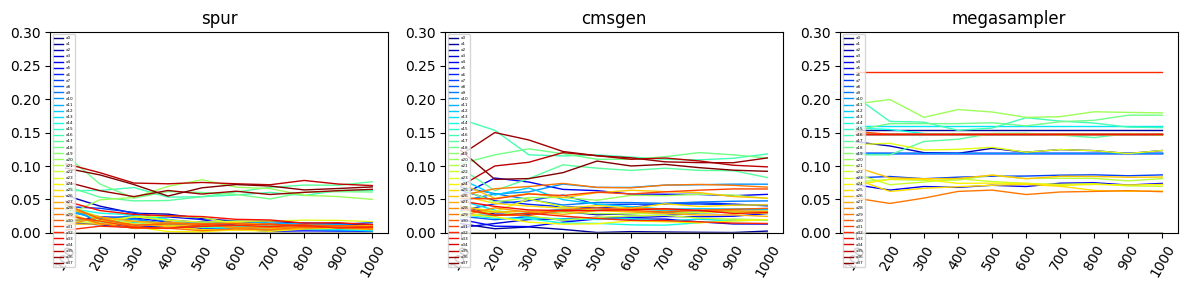

In [94]:
### Plot absolute distance for all variables (averaged on outcomes)
### for an increasing number of samples

batches = np.arange(100, 1001, step=100)

fig, axs = plt.subplots(1,3,figsize=(12,3))
# fig, ax = plt.subplots(1,figsize=(10,4))

avg_abs_dist = {b: [] for b in backends}

var_names = [f'x{i}' for i in range(19*2)]
cmap = plt.get_cmap('jet')
colors = cmap(np.linspace(0, 1.0, len(var_names)))


for b,i,ax in zip(backends,range(3),axs):
    for (x,c) in zip(var_names,colors):
        res = []
        for batch in batches:
            # function to easily query the estimated mean for a variable and outcome
            def p_est(var, outcome, batch, i):
                toi = traces_nz_stats[i].posterior.sel(chain=0,draw=np.arange(batch))[var]
                return np.mean(toi == outcome).item()

            ## ranges are variable specific for DB cacm
            var_int_id = int(x[1:])
            ran = get_values(numpy_data[int(var_int_id > 18),(var_int_id%19)])

            abs_dist = [np.abs(p_var_nz_stats(var_int_id,o) - p_est(x,o,batch,i)) for o in ran]
            res.append(sum(abs_dist)/len(abs_dist))
            # print(x,b,batch,abs_dist,res) # debug
        ax.plot(res, color=c, label=x, lw=1)
        avg_abs_dist[b].append(res[-1:][0])
    ax.set_xticks(np.arange(len(batches)),batches,rotation=60)
    ax.set_title(b)
    ax.set_ylim(ymin=0.0, ymax=0.3)
    ax.legend(loc=2, prop={'size': 3})
plt.show();

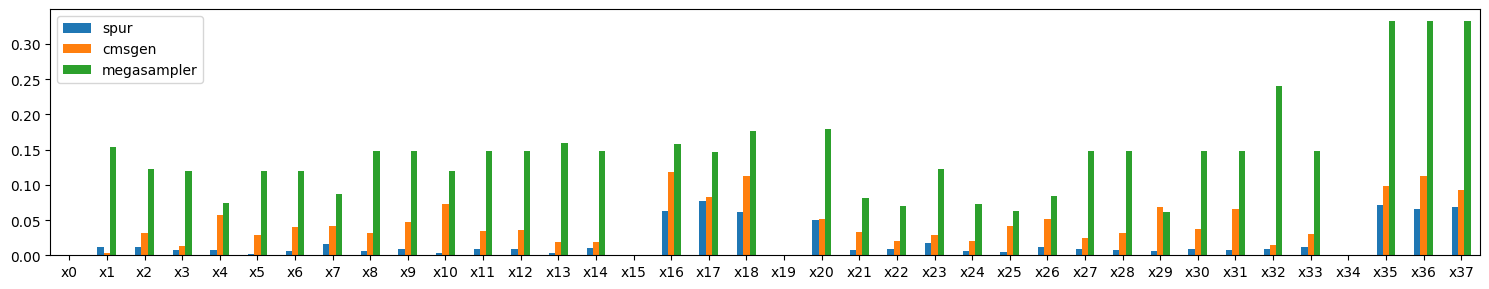

In [93]:
### Plot the absolute distance for the average mean over all outcomes
### for the largest number of samples
df1 = pd.DataFrame(avg_abs_dist)
ax  = df1.plot.bar(figsize=(15,3))
ax.set_xticks(np.arange(19*2), [f'x{i}' for i in range(19*2)], rotation=0);

## Roads

In [4]:
TIMEOUT = 60*10 # seconds (10min)

# implicit 4 connections, and a reduction factor of 11 for the y values

(g, num_bits, num_vars) = models.get_roads_sat(num_bits = 7,
                                               max_int_bv = 2**5-1)
(s, num_vars) = models.get_roads_smt(max_int = 2**5-1)
backends = ['spur', 'cmsgen', 'megasampler']
traces_roads = [ 
    mcmc.sample_mh_trace_from_z3_model(backend=backend,
                                       z3_problem=g,
                                       num_bits=num_bits,
                                       num_vars=num_vars,
                                       timeout_sampler=TIMEOUT,
                                       num_samples=1000)
    if backend in ['spur','cmsgen']
    else mcmc.sample_mh_trace_from_z3_model(
            backend=backend,
            z3_problem=s,
            reweight_samples=True,
            timeout_sampler=TIMEOUT,
            num_samples=1000)
    for backend in backends ]

[(1, 2), (1, 3), (1, 4), (1, 5), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (4, 5)]
[(1, 2), (1, 3), (1, 4), (1, 5), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (4, 5)]


Using default filename: "spur_input/samples_z3_problem.txt"
Performing Uniform Model Sampling...
Input File:  spur_input/z3_problem.cnf
Output File: spur_input/samples_z3_problem.txt

Preprocessing ... DONE
variables (all/used/free): 	826/826/0
independent support size:  	0
clauses (all/long/binary/unit): 3788/2987/766/35
Initialize cache
Size of Cacheable Component:	56
Size of MPZ Class:	16
Maximum cache size:	1482 MB

STAGE #1: Build the initial partial assignments


STAGE #1: COMPLETED building initial partial assignments
STAGE #2 - Filling in partial assignments...
Initialize cache
Size of Cacheable Component:	56
Size of MPZ Class:	16
Maximum cache size:	1482 MB

Sample #1 of 320 is already a complete assignment.  Continuing...
Completing sample #2 of 320 which has 75 variables unset and 1 sample.
Completing sample #3 of 320 which has 70 variables unset and 1 sample.
Completing sample #4 of 320 which has 17 variables unset and 4 samples.
Completing sample #5 of 320 which has 17 variables unset and 1 sample.
Completing sample #6 of 320 which has 100 variables unset and 1 sample.
Completing sample #7 of 320 which has 41 variables unset and 2 samples.
Completing sample #8 of 320 which has 76 variables unset and 2 samples.
Completing sample #9 of 320 which has 56 variables unset and 1 sample.
Completing sample #10 of 320 which has 170 variables unset and 1 sample.
Completing sample #11 of 320 which has 73 variables unset and 1 sample.
Completing samp

Completing sample #54 of 320 which has 61 variables unset and 1 sample.
Completing sample #55 of 320 which has 52 variables unset and 1 sample.
Completing sample #56 of 320 which has 70 variables unset and 1 sample.
Completing sample #57 of 320 which has 51 variables unset and 1 sample.
Completing sample #58 of 320 which has 58 variables unset and 1 sample.
Completing sample #59 of 320 which has 33 variables unset and 1 sample.
Completing sample #60 of 320 which has 68 variables unset and 1 sample.
Completing sample #61 of 320 which has 75 variables unset and 2 samples.
Completing sample #62 of 320 which has 72 variables unset and 1 sample.
Completing sample #63 of 320 which has 61 variables unset and 1 sample.
Completing sample #64 of 320 which has 64 variables unset and 1 sample.
Completing sample #65 of 320 which has 38 variables unset and 1 sample.
Completing sample #66 of 320 which has 62 variables unset and 1 sample.
Completing sample #67 of 320 which has 33 variables unset and 2

Completing sample #128 of 320 which has 35 variables unset and 1 sample.
Completing sample #129 of 320 which has 74 variables unset and 1 sample.
Completing sample #130 of 320 which has 65 variables unset and 1 sample.
Completing sample #131 of 320 which has 63 variables unset and 1 sample.
Completing sample #132 of 320 which has 48 variables unset and 1 sample.
Completing sample #133 of 320 which has 48 variables unset and 2 samples.
Completing sample #134 of 320 which has 54 variables unset and 1 sample.
Completing sample #135 of 320 which has 67 variables unset and 1 sample.
Completing sample #136 of 320 which has 36 variables unset and 1 sample.
Completing sample #137 of 320 which has 66 variables unset and 1 sample.
Completing sample #138 of 320 which has 85 variables unset and 4 samples.
Completing sample #139 of 320 which has 66 variables unset and 1 sample.
Completing sample #140 of 320 which has 73 variables unset and 1 sample.
Completing sample #141 of 320 which has 65 variab

Completing sample #200 of 320 which has 68 variables unset and 1 sample.
Completing sample #201 of 320 which has 70 variables unset and 1 sample.
Completing sample #202 of 320 which has 70 variables unset and 1 sample.
Completing sample #203 of 320 which has 62 variables unset and 1 sample.
Completing sample #204 of 320 which has 79 variables unset and 1 sample.
Completing sample #205 of 320 which has 66 variables unset and 1 sample.
Completing sample #206 of 320 which has 62 variables unset and 1 sample.
Completing sample #207 of 320 which has 63 variables unset and 1 sample.
Completing sample #208 of 320 which has 82 variables unset and 2 samples.
Completing sample #209 of 320 which has 77 variables unset and 1 sample.
Completing sample #210 of 320 which has 70 variables unset and 2 samples.
Completing sample #211 of 320 which has 68 variables unset and 1 sample.
Completing sample #212 of 320 which has 75 variables unset and 1 sample.
Completing sample #213 of 320 which has 77 variab

Completing sample #271 of 320 which has 20 variables unset and 1 sample.
Completing sample #272 of 320 which has 43 variables unset and 1 sample.
Completing sample #273 of 320 which has 83 variables unset and 2 samples.
Completing sample #274 of 320 which has 46 variables unset and 1 sample.
Completing sample #275 of 320 which has 83 variables unset and 1 sample.
Completing sample #276 of 320 which has 49 variables unset and 1 sample.
Completing sample #277 of 320 which has 94 variables unset and 3 samples.
Completing sample #278 of 320 which has 45 variables unset and 1 sample.
Completing sample #279 of 320 which has 83 variables unset and 1 sample.
Completing sample #280 of 320 which has 53 variables unset and 1 sample.
Completing sample #281 of 320 which has 30 variables unset and 1 sample.
Completing sample #282 of 320 which has 80 variables unset and 1 sample.
Completing sample #283 of 320 which has 58 variables unset and 1 sample.
Completing sample #284 of 320 which has 85 variab

c CMSGen Copyright Mate Soos (soos.mate@gmail.com)
c CMSGen SHA revision 00791438b32bb387e1f6ba7c1b211d7f6595aa06
c CMSGen is MIT licensed
c CMSGen compilation env CMAKE_CXX_COMPILER = /usr/bin/c++ | CMAKE_CXX_FLAGS =  -fno-stack-protector -mtune=native -Wlogical-op -Wrestrict -Wnull-dereference -Wdouble-promotion -Wshadow -Wformat=2 -Wextra-semi -pedantic | COMPILE_DEFINES =  -DNDEBUG -D_FORTIFY_SOURCE=0 -DUSE_GAUSS -DUSE_ZLIB -DYALSAT_FPU | STATICCOMPILE = ON | ZLIB_FOUND = TRUE | VALGRIND_FOUND =  | ENABLE_TESTING = ON | SLOW_DEBUG = OFF | ENABLE_ASSERTIONS = OFF | MY_TARGETS =  | LARGEMEM =  | LIMITMEM =  | 
c CMSGen compiled with gcc version 9.4.0
c executed with command line: cmsgen --samples 1000 --samplefile cmsgen_input/cmsgen_samples.out cmsgen_input/z3_problem.cnf
c Writing samples to file: cmsgen_input/cmsgen_samples.out


c Number of samples found until now:     10


c Number of samples found until now:     20
c Number of samples found until now:     30


c Number of samples found until now:     40


c Number of samples found until now:     50


c Number of samples found until now:     60


c Number of samples found until now:     70


c Number of samples found until now:     80
c Number of samples found until now:     90


c Number of samples found until now:    100


c Number of samples found until now:    110


c Number of samples found until now:    120


c Number of samples found until now:    130
c Number of samples found until now:    140


c Number of samples found until now:    150
c Number of samples found until now:    160


c Number of samples found until now:    170


c Number of samples found until now:    180
c Number of samples found until now:    190


c Number of samples found until now:    200
c Number of samples found until now:    210


c Number of samples found until now:    220
c Number of samples found until now:    230


c Number of samples found until now:    240
c Number of samples found until now:    250


c Number of samples found until now:    260
c Number of samples found until now:    270


c Number of samples found until now:    280
c Number of samples found until now:    290


c Number of samples found until now:    300
c Number of samples found until now:    310


c Number of samples found until now:    320
c Number of samples found until now:    330


c Number of samples found until now:    340


c Number of samples found until now:    350
c Number of samples found until now:    360


c Number of samples found until now:    370
c Number of samples found until now:    380
c Number of samples found until now:    390


c Number of samples found until now:    400
c Number of samples found until now:    410


c Number of samples found until now:    420
c Number of samples found until now:    430
c Number of samples found until now:    440


c Number of samples found until now:    450
c Number of samples found until now:    460


c Number of samples found until now:    470
c Number of samples found until now:    480


c Number of samples found until now:    490
c Number of samples found until now:    500
c Number of samples found until now:    510


c Number of samples found until now:    520
c Number of samples found until now:    530
c Number of samples found until now:    540


c Number of samples found until now:    550
c Number of samples found until now:    560
c Number of samples found until now:    570


c Number of samples found until now:    580
c Number of samples found until now:    590


c Number of samples found until now:    600
c Number of samples found until now:    610
c Number of samples found until now:    620


c Number of samples found until now:    630


c Number of samples found until now:    640
c Number of samples found until now:    650
c Number of samples found until now:    660


c Number of samples found until now:    670
c Number of samples found until now:    680
c Number of samples found until now:    690


c Number of samples found until now:    700
c Number of samples found until now:    710
c Number of samples found until now:    720


c Number of samples found until now:    730
c Number of samples found until now:    740
c Number of samples found until now:    750


c Number of samples found until now:    760
c Number of samples found until now:    770
c Number of samples found until now:    780


c Number of samples found until now:    790
c Number of samples found until now:    800


c Number of samples found until now:    810
c Number of samples found until now:    820
c Number of samples found until now:    830


c Number of samples found until now:    840
c Number of samples found until now:    850
c Number of samples found until now:    860


c Number of samples found until now:    870
c Number of samples found until now:    880
c Number of samples found until now:    890


c Number of samples found until now:    900
c Number of samples found until now:    910
c Number of samples found until now:    920


c Number of samples found until now:    930
c Number of samples found until now:    940
c Number of samples found until now:    950


c Number of samples found until now:    960
c Number of samples found until now:    970
c Number of samples found until now:    980


c Number of samples found until now:    990
c Finished generating all 1000 samples
c Total time: 15 s 


Parsing input file: megasampler_input/z3_problem.smt2
Number of formulas in file: 24
-------------FORMULA STATISTICS-------------
Arrays 0
Bit-vectors 0
Bools 0
Bits 0
Uninterpreted functions 0
Ints 10
Reals 0
Formula tree depth 2
--------------------------------------------
starting MeGASampler


Formula is satisfiable
---------SOLVING STATISTICS--------
do_epoch time: 66.0444
epoch time: 99.4237
grow_seed time: 2.66354
initial_solving time: 0.00385631
output time: 0.179608
start_epoch time: 33.3661
total time: 99.4374
Epochs: 8508
MAX-SMT calls: 8509
SMT calls: 0
Assignments considered (with repetitions): 867715
Models (with repetitions): 867715
Unique models (# samples in file): 1000
-----------------------------------


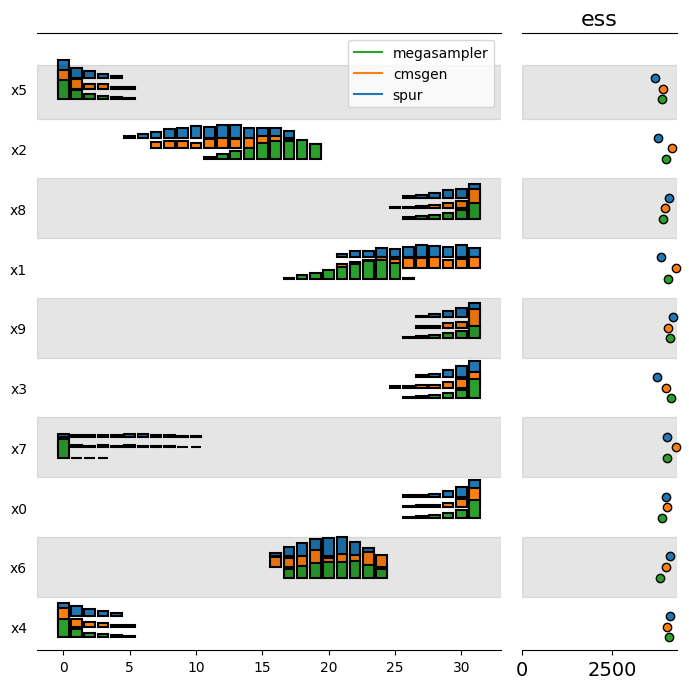

In [6]:
az.plot_forest(traces_roads, combined=True, model_names=backends, hdi_prob=0.95, kind='ridgeplot', figsize=(7,7), ess=True);

## Books

In [9]:
TIMEOUT = 60*10 # seconds (10min)

# implicit bound of 9, and a max_int of 86/6

(g, num_bits, num_vars) = models.get_books_sat()
(s, num_vars) = models.get_books_smt()

backends = ['spur', 'cmsgen']
# backends = ['spur', 'cmsgen', 'megasampler'] ## megasampler not working

traces_books = [ 
    mcmc.sample_mh_trace_from_z3_model(backend=backend,
                                       z3_problem=g,
                                       num_bits=num_bits,
                                       num_vars=num_vars,
                                       timeout_sampler=TIMEOUT,
                                       num_samples=1000)
    if backend in ['spur','cmsgen']
    else mcmc.sample_mh_trace_from_z3_model(
            backend=backend,
            z3_problem=s,
            reweight_samples=True,
            algo = 'MeGAb',
            timeout_sampler=TIMEOUT,
            num_samples=1000)
    for backend in backends ]

Using default filename: "spur_input/samples_z3_problem.txt"
Performing Uniform Model Sampling...
Input File:  spur_input/z3_problem.cnf
Output File: spur_input/samples_z3_problem.txt

Preprocessing ... DONE
variables (all/used/free): 	2754/2754/0
independent support size:  	0
clauses (all/long/binary/unit): 10688/7655/2863/170
Initialize cache
Size of Cacheable Component:	56
Size of MPZ Class:	16
Maximum cache size:	797 MB

STAGE #1: Build the initial partial assignments


STAGE #1: COMPLETED building initial partial assignments
STAGE #2 - Filling in partial assignments...


Initialize cache
Size of Cacheable Component:	56
Size of MPZ Class:	16

 Free RAM 418MB
Maximum cache size:	797 MB

Completing sample #1 of 1000 which has 126 variables unset and 1 sample.
Completing sample #2 of 1000 which has 143 variables unset and 1 sample.
Completing sample #3 of 1000 which has 105 variables unset and 1 sample.
Completing sample #4 of 1000 which has 164 variables unset and 1 sample.
Completing sample #5 of 1000 which has 193 variables unset and 1 sample.
Completing sample #6 of 1000 which has 155 variables unset and 1 sample.
Completing sample #7 of 1000 which has 66 variables unset and 1 sample.
Completing sample #8 of 1000 which has 195 variables unset and 1 sample.
Completing sample #9 of 1000 which has 90 variables unset and 1 sample.
Completing sample #10 of 1000 which has 317 variables unset and 1 sample.
Completing sample #11 of 1000 which has 31 variables unset and 1 sample.
Completing sample #12 of 1000 which has 141 variables unset and 1 sample.
Completi

Completing sample #20 of 1000 which has 265 variables unset and 1 sample.
Completing sample #21 of 1000 which has 68 variables unset and 1 sample.
Completing sample #22 of 1000 which has 141 variables unset and 1 sample.
Completing sample #23 of 1000 which has 56 variables unset and 1 sample.
Completing sample #24 of 1000 which has 236 variables unset and 1 sample.
Completing sample #25 of 1000 which has 258 variables unset and 1 sample.
Completing sample #26 of 1000 which has 147 variables unset and 1 sample.
Completing sample #27 of 1000 which has 32 variables unset and 1 sample.
Completing sample #28 of 1000 which has 106 variables unset and 1 sample.
Completing sample #29 of 1000 which has 127 variables unset and 1 sample.
Completing sample #30 of 1000 which has 334 variables unset and 1 sample.
Completing sample #31 of 1000 which has 191 variables unset and 1 sample.
Completing sample #32 of 1000 which has 146 variables unset and 1 sample.
Completing sample #33 of 1000 which has 1

Completing sample #41 of 1000 which has 78 variables unset and 1 sample.
Completing sample #42 of 1000 which has 255 variables unset and 1 sample.
Completing sample #43 of 1000 which has 151 variables unset and 1 sample.
Completing sample #44 of 1000 which has 157 variables unset and 1 sample.
Completing sample #45 of 1000 which has 223 variables unset and 1 sample.
Completing sample #46 of 1000 which has 131 variables unset and 1 sample.
Completing sample #47 of 1000 which has 160 variables unset and 1 sample.
Completing sample #48 of 1000 which has 136 variables unset and 1 sample.
Completing sample #49 of 1000 which has 102 variables unset and 1 sample.
Completing sample #50 of 1000 which has 83 variables unset and 1 sample.
Completing sample #51 of 1000 which has 119 variables unset and 1 sample.
Completing sample #52 of 1000 which has 177 variables unset and 1 sample.
Completing sample #53 of 1000 which has 102 variables unset and 1 sample.
Completing sample #54 of 1000 which has 

Completing sample #60 of 1000 which has 163 variables unset and 1 sample.
Completing sample #61 of 1000 which has 152 variables unset and 1 sample.
Completing sample #62 of 1000 which has 148 variables unset and 1 sample.
Completing sample #63 of 1000 which has 111 variables unset and 1 sample.
Completing sample #64 of 1000 which has 95 variables unset and 1 sample.
Completing sample #65 of 1000 which has 152 variables unset and 1 sample.
Completing sample #66 of 1000 which has 176 variables unset and 1 sample.
Completing sample #67 of 1000 which has 107 variables unset and 1 sample.
Completing sample #68 of 1000 which has 79 variables unset and 1 sample.
Completing sample #69 of 1000 which has 129 variables unset and 1 sample.
Completing sample #70 of 1000 which has 164 variables unset and 1 sample.
Completing sample #71 of 1000 which has 107 variables unset and 1 sample.
Completing sample #72 of 1000 which has 92 variables unset and 1 sample.
Completing sample #73 of 1000 which has 2

Completing sample #81 of 1000 which has 101 variables unset and 1 sample.
Completing sample #82 of 1000 which has 134 variables unset and 1 sample.
Completing sample #83 of 1000 which has 192 variables unset and 1 sample.
Completing sample #84 of 1000 which has 49 variables unset and 1 sample.
Completing sample #85 of 1000 which has 103 variables unset and 1 sample.
Completing sample #86 of 1000 which has 90 variables unset and 1 sample.
Completing sample #87 of 1000 which has 57 variables unset and 1 sample.
Completing sample #88 of 1000 which has 50 variables unset and 1 sample.
Completing sample #89 of 1000 which has 118 variables unset and 1 sample.
Completing sample #90 of 1000 which has 236 variables unset and 1 sample.
Completing sample #91 of 1000 which has 177 variables unset and 1 sample.
Completing sample #92 of 1000 which has 172 variables unset and 1 sample.
Completing sample #93 of 1000 which has 137 variables unset and 1 sample.
Completing sample #94 of 1000 which has 13

Completing sample #101 of 1000 which has 130 variables unset and 1 sample.
Completing sample #102 of 1000 which has 238 variables unset and 1 sample.
Completing sample #103 of 1000 which has 149 variables unset and 1 sample.
Completing sample #104 of 1000 which has 165 variables unset and 1 sample.
Completing sample #105 of 1000 which has 144 variables unset and 1 sample.
Completing sample #106 of 1000 which has 125 variables unset and 1 sample.
Completing sample #107 of 1000 which has 94 variables unset and 1 sample.
Completing sample #108 of 1000 which has 145 variables unset and 1 sample.
Completing sample #109 of 1000 which has 132 variables unset and 1 sample.
Completing sample #110 of 1000 which has 165 variables unset and 1 sample.
Completing sample #111 of 1000 which has 62 variables unset and 1 sample.
Completing sample #112 of 1000 which has 153 variables unset and 1 sample.
Completing sample #113 of 1000 which has 169 variables unset and 1 sample.
Completing sample #114 of 1

Completing sample #121 of 1000 which has 75 variables unset and 1 sample.
Completing sample #122 of 1000 which has 117 variables unset and 1 sample.
Completing sample #123 of 1000 which has 172 variables unset and 1 sample.
Completing sample #124 of 1000 which has 82 variables unset and 1 sample.
Completing sample #125 of 1000 which has 131 variables unset and 1 sample.
Completing sample #126 of 1000 which has 175 variables unset and 1 sample.
Completing sample #127 of 1000 which has 113 variables unset and 1 sample.
Completing sample #128 of 1000 which has 154 variables unset and 1 sample.
Completing sample #129 of 1000 which has 141 variables unset and 1 sample.
Completing sample #130 of 1000 which has 128 variables unset and 1 sample.
Completing sample #131 of 1000 which has 92 variables unset and 1 sample.
Completing sample #132 of 1000 which has 86 variables unset and 1 sample.
Completing sample #133 of 1000 which has 121 variables unset and 1 sample.
Completing sample #134 of 100

Completing sample #141 of 1000 which has 130 variables unset and 1 sample.
Completing sample #142 of 1000 which has 129 variables unset and 1 sample.
Completing sample #143 of 1000 which has 214 variables unset and 1 sample.
Completing sample #144 of 1000 which has 132 variables unset and 1 sample.
Completing sample #145 of 1000 which has 171 variables unset and 1 sample.
Completing sample #146 of 1000 which has 92 variables unset and 1 sample.
Completing sample #147 of 1000 which has 230 variables unset and 1 sample.
Completing sample #148 of 1000 which has 212 variables unset and 1 sample.
Completing sample #149 of 1000 which has 216 variables unset and 1 sample.
Completing sample #150 of 1000 which has 128 variables unset and 1 sample.
Completing sample #151 of 1000 which has 129 variables unset and 1 sample.
Completing sample #152 of 1000 which has 142 variables unset and 1 sample.
Completing sample #153 of 1000 which has 181 variables unset and 1 sample.
Completing sample #154 of 

Completing sample #160 of 1000 which has 137 variables unset and 1 sample.
Completing sample #161 of 1000 which has 169 variables unset and 1 sample.
Completing sample #162 of 1000 which has 143 variables unset and 1 sample.
Completing sample #163 of 1000 which has 98 variables unset and 1 sample.
Completing sample #164 of 1000 which has 168 variables unset and 1 sample.
Completing sample #165 of 1000 which has 113 variables unset and 1 sample.
Completing sample #166 of 1000 which has 130 variables unset and 1 sample.
Completing sample #167 of 1000 which has 138 variables unset and 1 sample.
Completing sample #168 of 1000 which has 138 variables unset and 1 sample.
Completing sample #169 of 1000 which has 107 variables unset and 1 sample.
Completing sample #170 of 1000 which has 82 variables unset and 1 sample.
Completing sample #171 of 1000 which has 198 variables unset and 1 sample.
Completing sample #172 of 1000 which has 56 variables unset and 1 sample.
Completing sample #173 of 10

Completing sample #179 of 1000 which has 92 variables unset and 1 sample.
Completing sample #180 of 1000 which has 175 variables unset and 1 sample.
Completing sample #181 of 1000 which has 88 variables unset and 1 sample.
Completing sample #182 of 1000 which has 235 variables unset and 1 sample.
Completing sample #183 of 1000 which has 121 variables unset and 1 sample.
Completing sample #184 of 1000 which has 68 variables unset and 1 sample.
Completing sample #185 of 1000 which has 137 variables unset and 1 sample.
Completing sample #186 of 1000 which has 166 variables unset and 1 sample.
Completing sample #187 of 1000 which has 179 variables unset and 1 sample.
Completing sample #188 of 1000 which has 154 variables unset and 1 sample.
Completing sample #189 of 1000 which has 167 variables unset and 1 sample.
Completing sample #190 of 1000 which has 186 variables unset and 1 sample.
Completing sample #191 of 1000 which has 105 variables unset and 1 sample.
Completing sample #192 of 10

Completing sample #198 of 1000 which has 110 variables unset and 1 sample.
Completing sample #199 of 1000 which has 76 variables unset and 1 sample.
Completing sample #200 of 1000 which has 162 variables unset and 1 sample.
Completing sample #201 of 1000 which has 129 variables unset and 1 sample.
Completing sample #202 of 1000 which has 83 variables unset and 1 sample.
Completing sample #203 of 1000 which has 118 variables unset and 1 sample.
Completing sample #204 of 1000 which has 144 variables unset and 1 sample.
Completing sample #205 of 1000 which has 120 variables unset and 1 sample.
Completing sample #206 of 1000 which has 146 variables unset and 1 sample.
Completing sample #207 of 1000 which has 91 variables unset and 1 sample.
Completing sample #208 of 1000 which has 96 variables unset and 1 sample.
Completing sample #209 of 1000 which has 96 variables unset and 1 sample.
Completing sample #210 of 1000 which has 172 variables unset and 1 sample.
Completing sample #211 of 1000

Completing sample #217 of 1000 which has 148 variables unset and 1 sample.
Completing sample #218 of 1000 which has 123 variables unset and 1 sample.
Completing sample #219 of 1000 which has 151 variables unset and 1 sample.
Completing sample #220 of 1000 which has 186 variables unset and 1 sample.
Completing sample #221 of 1000 which has 121 variables unset and 1 sample.
Completing sample #222 of 1000 which has 160 variables unset and 1 sample.
Completing sample #223 of 1000 which has 72 variables unset and 1 sample.
Completing sample #224 of 1000 which has 73 variables unset and 1 sample.
Completing sample #225 of 1000 which has 231 variables unset and 1 sample.
Completing sample #226 of 1000 which has 204 variables unset and 1 sample.
Completing sample #227 of 1000 which has 130 variables unset and 1 sample.
Completing sample #228 of 1000 which has 121 variables unset and 1 sample.
Completing sample #229 of 1000 which has 109 variables unset and 1 sample.
Completing sample #230 of 1

Completing sample #236 of 1000 which has 130 variables unset and 1 sample.
Completing sample #237 of 1000 which has 98 variables unset and 1 sample.
Completing sample #238 of 1000 which has 164 variables unset and 1 sample.
Completing sample #239 of 1000 which has 92 variables unset and 1 sample.
Completing sample #240 of 1000 which has 109 variables unset and 1 sample.
Completing sample #241 of 1000 which has 85 variables unset and 1 sample.
Completing sample #242 of 1000 which has 234 variables unset and 1 sample.
Completing sample #243 of 1000 which has 151 variables unset and 1 sample.
Completing sample #244 of 1000 which has 186 variables unset and 1 sample.
Completing sample #245 of 1000 which has 180 variables unset and 1 sample.
Completing sample #246 of 1000 which has 184 variables unset and 1 sample.
Completing sample #247 of 1000 which has 154 variables unset and 1 sample.
Completing sample #248 of 1000 which has 166 variables unset and 1 sample.
Completing sample #249 of 10

Completing sample #255 of 1000 which has 188 variables unset and 1 sample.
Completing sample #256 of 1000 which has 100 variables unset and 1 sample.
Completing sample #257 of 1000 which has 80 variables unset and 1 sample.
Completing sample #258 of 1000 which has 155 variables unset and 1 sample.
Completing sample #259 of 1000 which has 70 variables unset and 1 sample.
Completing sample #260 of 1000 which has 37 variables unset and 1 sample.
Completing sample #261 of 1000 which has 87 variables unset and 1 sample.
Completing sample #262 of 1000 which has 178 variables unset and 1 sample.
Completing sample #263 of 1000 which has 105 variables unset and 1 sample.
Completing sample #264 of 1000 which has 76 variables unset and 1 sample.
Completing sample #265 of 1000 which has 184 variables unset and 1 sample.
Completing sample #266 of 1000 which has 155 variables unset and 1 sample.
Completing sample #267 of 1000 which has 64 variables unset and 1 sample.
Completing sample #268 of 1000 

Completing sample #273 of 1000 which has 92 variables unset and 1 sample.
Completing sample #274 of 1000 which has 171 variables unset and 1 sample.
Completing sample #275 of 1000 which has 192 variables unset and 1 sample.
Completing sample #276 of 1000 which has 176 variables unset and 1 sample.
Completing sample #277 of 1000 which has 147 variables unset and 1 sample.
Completing sample #278 of 1000 which has 169 variables unset and 1 sample.
Completing sample #279 of 1000 which has 121 variables unset and 1 sample.
Completing sample #280 of 1000 which has 143 variables unset and 1 sample.
Completing sample #281 of 1000 which has 139 variables unset and 1 sample.
Completing sample #282 of 1000 which has 144 variables unset and 1 sample.
Completing sample #283 of 1000 which has 44 variables unset and 1 sample.
Completing sample #284 of 1000 which has 112 variables unset and 1 sample.
Completing sample #285 of 1000 which has 306 variables unset and 1 sample.
Completing sample #286 of 1

Completing sample #292 of 1000 which has 147 variables unset and 1 sample.
Completing sample #293 of 1000 which has 81 variables unset and 1 sample.
Completing sample #294 of 1000 which has 111 variables unset and 1 sample.
Completing sample #295 of 1000 which has 138 variables unset and 1 sample.
Completing sample #296 of 1000 which has 133 variables unset and 1 sample.
Completing sample #297 of 1000 which has 165 variables unset and 1 sample.
Completing sample #298 of 1000 which has 139 variables unset and 1 sample.
Completing sample #299 of 1000 which has 190 variables unset and 1 sample.
Completing sample #300 of 1000 which has 156 variables unset and 1 sample.
Completing sample #301 of 1000 which has 140 variables unset and 1 sample.
Completing sample #302 of 1000 which has 130 variables unset and 1 sample.
Completing sample #303 of 1000 which has 204 variables unset and 1 sample.
Completing sample #304 of 1000 which has 165 variables unset and 1 sample.
Completing sample #305 of 

Completing sample #311 of 1000 which has 82 variables unset and 1 sample.
Completing sample #312 of 1000 which has 153 variables unset and 1 sample.
Completing sample #313 of 1000 which has 63 variables unset and 1 sample.
Completing sample #314 of 1000 which has 77 variables unset and 1 sample.
Completing sample #315 of 1000 which has 133 variables unset and 1 sample.
Completing sample #316 of 1000 which has 87 variables unset and 1 sample.
Completing sample #317 of 1000 which has 207 variables unset and 1 sample.
Completing sample #318 of 1000 which has 186 variables unset and 1 sample.
Completing sample #319 of 1000 which has 142 variables unset and 1 sample.
Completing sample #320 of 1000 which has 122 variables unset and 1 sample.
Completing sample #321 of 1000 which has 113 variables unset and 1 sample.
Completing sample #322 of 1000 which has 147 variables unset and 1 sample.
Completing sample #323 of 1000 which has 113 variables unset and 1 sample.
Completing sample #324 of 100

Completing sample #330 of 1000 which has 171 variables unset and 1 sample.
Completing sample #331 of 1000 which has 151 variables unset and 1 sample.
Completing sample #332 of 1000 which has 142 variables unset and 1 sample.
Completing sample #333 of 1000 which has 124 variables unset and 1 sample.
Completing sample #334 of 1000 which has 92 variables unset and 1 sample.
Completing sample #335 of 1000 which has 173 variables unset and 1 sample.
Completing sample #336 of 1000 which has 113 variables unset and 1 sample.
Completing sample #337 of 1000 which has 130 variables unset and 1 sample.
Completing sample #338 of 1000 which has 165 variables unset and 1 sample.
Completing sample #339 of 1000 which has 107 variables unset and 1 sample.
Completing sample #340 of 1000 which has 173 variables unset and 1 sample.
Completing sample #341 of 1000 which has 47 variables unset and 1 sample.
Completing sample #342 of 1000 which has 147 variables unset and 1 sample.
Completing sample #343 of 1

Completing sample #349 of 1000 which has 79 variables unset and 1 sample.
Completing sample #350 of 1000 which has 167 variables unset and 1 sample.
Completing sample #351 of 1000 which has 92 variables unset and 1 sample.
Completing sample #352 of 1000 which has 148 variables unset and 1 sample.
Completing sample #353 of 1000 which has 164 variables unset and 1 sample.
Completing sample #354 of 1000 which has 170 variables unset and 1 sample.
Completing sample #355 of 1000 which has 135 variables unset and 1 sample.
Completing sample #356 of 1000 which has 190 variables unset and 1 sample.
Completing sample #357 of 1000 which has 82 variables unset and 1 sample.
Completing sample #358 of 1000 which has 147 variables unset and 1 sample.
Completing sample #359 of 1000 which has 105 variables unset and 1 sample.
Completing sample #360 of 1000 which has 185 variables unset and 1 sample.
Completing sample #361 of 1000 which has 174 variables unset and 1 sample.
Completing sample #362 of 10

Completing sample #368 of 1000 which has 62 variables unset and 1 sample.
Completing sample #369 of 1000 which has 154 variables unset and 1 sample.
Completing sample #370 of 1000 which has 264 variables unset and 1 sample.
Completing sample #371 of 1000 which has 82 variables unset and 1 sample.
Completing sample #372 of 1000 which has 24 variables unset and 1 sample.
Completing sample #373 of 1000 which has 150 variables unset and 1 sample.
Completing sample #374 of 1000 which has 194 variables unset and 1 sample.
Completing sample #375 of 1000 which has 53 variables unset and 1 sample.
Completing sample #376 of 1000 which has 107 variables unset and 1 sample.
Completing sample #377 of 1000 which has 36 variables unset and 1 sample.
Completing sample #378 of 1000 which has 120 variables unset and 1 sample.
Completing sample #379 of 1000 which has 88 variables unset and 1 sample.
Completing sample #380 of 1000 which has 167 variables unset and 1 sample.
Completing sample #381 of 1000 

Completing sample #387 of 1000 which has 121 variables unset and 1 sample.
Completing sample #388 of 1000 which has 124 variables unset and 1 sample.
Completing sample #389 of 1000 which has 121 variables unset and 1 sample.
Completing sample #390 of 1000 which has 185 variables unset and 1 sample.
Completing sample #391 of 1000 which has 71 variables unset and 1 sample.
Completing sample #392 of 1000 which has 125 variables unset and 1 sample.
Completing sample #393 of 1000 which has 133 variables unset and 1 sample.
Completing sample #394 of 1000 which has 242 variables unset and 1 sample.
Completing sample #395 of 1000 which has 184 variables unset and 1 sample.
Completing sample #396 of 1000 which has 130 variables unset and 1 sample.
Completing sample #397 of 1000 which has 105 variables unset and 1 sample.
Completing sample #398 of 1000 which has 139 variables unset and 1 sample.
Completing sample #399 of 1000 which has 233 variables unset and 1 sample.
Completing sample #400 of 

Completing sample #406 of 1000 which has 136 variables unset and 1 sample.
Completing sample #407 of 1000 which has 77 variables unset and 1 sample.
Completing sample #408 of 1000 which has 174 variables unset and 1 sample.
Completing sample #409 of 1000 which has 125 variables unset and 1 sample.
Completing sample #410 of 1000 which has 242 variables unset and 1 sample.
Completing sample #411 of 1000 which has 102 variables unset and 1 sample.
Completing sample #412 of 1000 which has 216 variables unset and 1 sample.
Completing sample #413 of 1000 which has 239 variables unset and 1 sample.
Completing sample #414 of 1000 which has 27 variables unset and 1 sample.
Completing sample #415 of 1000 which has 85 variables unset and 1 sample.
Completing sample #416 of 1000 which has 129 variables unset and 1 sample.
Completing sample #417 of 1000 which has 141 variables unset and 1 sample.
Completing sample #418 of 1000 which has 144 variables unset and 1 sample.
Completing sample #419 of 10

Completing sample #425 of 1000 which has 164 variables unset and 1 sample.
Completing sample #426 of 1000 which has 158 variables unset and 1 sample.
Completing sample #427 of 1000 which has 185 variables unset and 1 sample.
Completing sample #428 of 1000 which has 175 variables unset and 1 sample.
Completing sample #429 of 1000 which has 109 variables unset and 1 sample.
Completing sample #430 of 1000 which has 136 variables unset and 1 sample.
Completing sample #431 of 1000 which has 191 variables unset and 1 sample.
Completing sample #432 of 1000 which has 141 variables unset and 1 sample.
Completing sample #433 of 1000 which has 115 variables unset and 1 sample.
Completing sample #434 of 1000 which has 94 variables unset and 1 sample.
Completing sample #435 of 1000 which has 93 variables unset and 1 sample.
Completing sample #436 of 1000 which has 104 variables unset and 1 sample.
Completing sample #437 of 1000 which has 114 variables unset and 1 sample.
Completing sample #438 of 1

Completing sample #444 of 1000 which has 123 variables unset and 1 sample.
Completing sample #445 of 1000 which has 126 variables unset and 1 sample.
Completing sample #446 of 1000 which has 178 variables unset and 1 sample.
Completing sample #447 of 1000 which has 80 variables unset and 1 sample.
Completing sample #448 of 1000 which has 179 variables unset and 1 sample.
Completing sample #449 of 1000 which has 78 variables unset and 1 sample.
Completing sample #450 of 1000 which has 164 variables unset and 1 sample.
Completing sample #451 of 1000 which has 179 variables unset and 1 sample.
Completing sample #452 of 1000 which has 167 variables unset and 1 sample.
Completing sample #453 of 1000 which has 36 variables unset and 1 sample.
Completing sample #454 of 1000 which has 108 variables unset and 1 sample.
Completing sample #455 of 1000 which has 218 variables unset and 1 sample.
Completing sample #456 of 1000 which has 78 variables unset and 1 sample.
Completing sample #457 of 100

Completing sample #463 of 1000 which has 168 variables unset and 1 sample.
Completing sample #464 of 1000 which has 133 variables unset and 1 sample.
Completing sample #465 of 1000 which has 188 variables unset and 1 sample.
Completing sample #466 of 1000 which has 159 variables unset and 1 sample.
Completing sample #467 of 1000 which has 100 variables unset and 1 sample.
Completing sample #468 of 1000 which has 138 variables unset and 1 sample.
Completing sample #469 of 1000 which has 86 variables unset and 1 sample.
Completing sample #470 of 1000 which has 137 variables unset and 1 sample.
Completing sample #471 of 1000 which has 150 variables unset and 1 sample.
Completing sample #472 of 1000 which has 226 variables unset and 1 sample.
Completing sample #473 of 1000 which has 197 variables unset and 1 sample.
Completing sample #474 of 1000 which has 215 variables unset and 1 sample.
Completing sample #475 of 1000 which has 70 variables unset and 1 sample.
Completing sample #476 of 1

Completing sample #482 of 1000 which has 156 variables unset and 1 sample.
Completing sample #483 of 1000 which has 186 variables unset and 1 sample.
Completing sample #484 of 1000 which has 165 variables unset and 1 sample.
Completing sample #485 of 1000 which has 198 variables unset and 1 sample.
Completing sample #486 of 1000 which has 75 variables unset and 1 sample.
Completing sample #487 of 1000 which has 103 variables unset and 1 sample.
Completing sample #488 of 1000 which has 24 variables unset and 1 sample.
Completing sample #489 of 1000 which has 135 variables unset and 1 sample.
Completing sample #490 of 1000 which has 136 variables unset and 1 sample.
Completing sample #491 of 1000 which has 187 variables unset and 1 sample.
Completing sample #492 of 1000 which has 181 variables unset and 1 sample.
Completing sample #493 of 1000 which has 127 variables unset and 1 sample.
Completing sample #494 of 1000 which has 65 variables unset and 1 sample.
Completing sample #495 of 10

Completing sample #501 of 1000 which has 231 variables unset and 1 sample.
Completing sample #502 of 1000 which has 98 variables unset and 1 sample.
Completing sample #503 of 1000 which has 51 variables unset and 1 sample.
Completing sample #504 of 1000 which has 152 variables unset and 1 sample.
Completing sample #505 of 1000 which has 96 variables unset and 1 sample.
Completing sample #506 of 1000 which has 73 variables unset and 1 sample.
Completing sample #507 of 1000 which has 156 variables unset and 1 sample.
Completing sample #508 of 1000 which has 93 variables unset and 1 sample.
Completing sample #509 of 1000 which has 159 variables unset and 1 sample.
Completing sample #510 of 1000 which has 131 variables unset and 1 sample.
Completing sample #511 of 1000 which has 114 variables unset and 1 sample.
Completing sample #512 of 1000 which has 181 variables unset and 1 sample.
Completing sample #513 of 1000 which has 134 variables unset and 1 sample.
Completing sample #514 of 1000

Completing sample #520 of 1000 which has 207 variables unset and 1 sample.
Completing sample #521 of 1000 which has 52 variables unset and 1 sample.
Completing sample #522 of 1000 which has 164 variables unset and 1 sample.
Completing sample #523 of 1000 which has 168 variables unset and 1 sample.
Completing sample #524 of 1000 which has 185 variables unset and 1 sample.
Completing sample #525 of 1000 which has 155 variables unset and 1 sample.
Completing sample #526 of 1000 which has 42 variables unset and 1 sample.
Completing sample #527 of 1000 which has 71 variables unset and 1 sample.
Completing sample #528 of 1000 which has 105 variables unset and 1 sample.
Completing sample #529 of 1000 which has 229 variables unset and 1 sample.
Completing sample #530 of 1000 which has 264 variables unset and 1 sample.
Completing sample #531 of 1000 which has 188 variables unset and 1 sample.
Completing sample #532 of 1000 which has 154 variables unset and 1 sample.
Completing sample #533 of 10

Completing sample #539 of 1000 which has 164 variables unset and 1 sample.
Completing sample #540 of 1000 which has 137 variables unset and 1 sample.
Completing sample #541 of 1000 which has 144 variables unset and 1 sample.
Completing sample #542 of 1000 which has 133 variables unset and 1 sample.
Completing sample #543 of 1000 which has 237 variables unset and 1 sample.
Completing sample #544 of 1000 which has 87 variables unset and 1 sample.
Completing sample #545 of 1000 which has 207 variables unset and 1 sample.
Completing sample #546 of 1000 which has 152 variables unset and 1 sample.
Completing sample #547 of 1000 which has 111 variables unset and 1 sample.
Completing sample #548 of 1000 which has 160 variables unset and 1 sample.
Completing sample #549 of 1000 which has 118 variables unset and 1 sample.
Completing sample #550 of 1000 which has 116 variables unset and 1 sample.
Completing sample #551 of 1000 which has 76 variables unset and 1 sample.
Completing sample #552 of 1

Completing sample #557 of 1000 which has 127 variables unset and 1 sample.
Completing sample #558 of 1000 which has 126 variables unset and 1 sample.
Completing sample #559 of 1000 which has 197 variables unset and 1 sample.
Completing sample #560 of 1000 which has 138 variables unset and 1 sample.
Completing sample #561 of 1000 which has 43 variables unset and 1 sample.
Completing sample #562 of 1000 which has 175 variables unset and 1 sample.
Completing sample #563 of 1000 which has 211 variables unset and 1 sample.
Completing sample #564 of 1000 which has 173 variables unset and 1 sample.
Completing sample #565 of 1000 which has 103 variables unset and 1 sample.
Completing sample #566 of 1000 which has 109 variables unset and 1 sample.
Completing sample #567 of 1000 which has 37 variables unset and 1 sample.
Completing sample #568 of 1000 which has 66 variables unset and 1 sample.
Completing sample #569 of 1000 which has 130 variables unset and 1 sample.
Completing sample #570 of 10

Completing sample #576 of 1000 which has 104 variables unset and 1 sample.
Completing sample #577 of 1000 which has 179 variables unset and 1 sample.
Completing sample #578 of 1000 which has 253 variables unset and 1 sample.
Completing sample #579 of 1000 which has 81 variables unset and 1 sample.
Completing sample #580 of 1000 which has 179 variables unset and 1 sample.
Completing sample #581 of 1000 which has 130 variables unset and 1 sample.
Completing sample #582 of 1000 which has 148 variables unset and 1 sample.
Completing sample #583 of 1000 which has 87 variables unset and 1 sample.
Completing sample #584 of 1000 which has 90 variables unset and 1 sample.
Completing sample #585 of 1000 which has 142 variables unset and 1 sample.
Completing sample #586 of 1000 which has 113 variables unset and 1 sample.
Completing sample #587 of 1000 which has 151 variables unset and 1 sample.
Completing sample #588 of 1000 which has 85 variables unset and 1 sample.
Completing sample #589 of 100

Completing sample #595 of 1000 which has 213 variables unset and 1 sample.
Completing sample #596 of 1000 which has 182 variables unset and 1 sample.
Completing sample #597 of 1000 which has 79 variables unset and 1 sample.
Completing sample #598 of 1000 which has 177 variables unset and 1 sample.
Completing sample #599 of 1000 which has 217 variables unset and 1 sample.
Completing sample #600 of 1000 which has 63 variables unset and 1 sample.
Completing sample #601 of 1000 which has 66 variables unset and 1 sample.
Completing sample #602 of 1000 which has 92 variables unset and 1 sample.
Completing sample #603 of 1000 which has 143 variables unset and 1 sample.
Completing sample #604 of 1000 which has 199 variables unset and 1 sample.
Completing sample #605 of 1000 which has 158 variables unset and 1 sample.
Completing sample #606 of 1000 which has 94 variables unset and 1 sample.
Completing sample #607 of 1000 which has 176 variables unset and 1 sample.
Completing sample #608 of 1000

Completing sample #614 of 1000 which has 107 variables unset and 1 sample.
Completing sample #615 of 1000 which has 246 variables unset and 1 sample.
Completing sample #616 of 1000 which has 224 variables unset and 1 sample.
Completing sample #617 of 1000 which has 157 variables unset and 1 sample.
Completing sample #618 of 1000 which has 157 variables unset and 1 sample.
Completing sample #619 of 1000 which has 136 variables unset and 1 sample.
Completing sample #620 of 1000 which has 76 variables unset and 1 sample.
Completing sample #621 of 1000 which has 81 variables unset and 1 sample.
Completing sample #622 of 1000 which has 110 variables unset and 1 sample.
Completing sample #623 of 1000 which has 64 variables unset and 1 sample.
Completing sample #624 of 1000 which has 174 variables unset and 1 sample.
Completing sample #625 of 1000 which has 131 variables unset and 1 sample.
Completing sample #626 of 1000 which has 222 variables unset and 1 sample.
Completing sample #627 of 10

Completing sample #633 of 1000 which has 244 variables unset and 1 sample.
Completing sample #634 of 1000 which has 150 variables unset and 1 sample.
Completing sample #635 of 1000 which has 170 variables unset and 1 sample.
Completing sample #636 of 1000 which has 102 variables unset and 1 sample.
Completing sample #637 of 1000 which has 188 variables unset and 1 sample.
Completing sample #638 of 1000 which has 147 variables unset and 1 sample.
Completing sample #639 of 1000 which has 208 variables unset and 1 sample.
Completing sample #640 of 1000 which has 205 variables unset and 1 sample.
Completing sample #641 of 1000 which has 117 variables unset and 1 sample.
Completing sample #642 of 1000 which has 164 variables unset and 1 sample.
Completing sample #643 of 1000 which has 124 variables unset and 1 sample.
Completing sample #644 of 1000 which has 103 variables unset and 1 sample.
Completing sample #645 of 1000 which has 25 variables unset and 1 sample.
Completing sample #646 of 

Completing sample #651 of 1000 which has 143 variables unset and 1 sample.
Completing sample #652 of 1000 which has 115 variables unset and 1 sample.
Completing sample #653 of 1000 which has 229 variables unset and 1 sample.
Completing sample #654 of 1000 which has 92 variables unset and 1 sample.
Completing sample #655 of 1000 which has 223 variables unset and 1 sample.
Completing sample #656 of 1000 which has 133 variables unset and 1 sample.
Completing sample #657 of 1000 which has 154 variables unset and 1 sample.
Completing sample #658 of 1000 which has 196 variables unset and 1 sample.
Completing sample #659 of 1000 which has 189 variables unset and 1 sample.
Completing sample #660 of 1000 which has 155 variables unset and 1 sample.
Completing sample #661 of 1000 which has 63 variables unset and 1 sample.
Completing sample #662 of 1000 which has 164 variables unset and 1 sample.
Completing sample #663 of 1000 which has 161 variables unset and 1 sample.
Completing sample #664 of 1

Completing sample #669 of 1000 which has 111 variables unset and 1 sample.
Completing sample #670 of 1000 which has 97 variables unset and 1 sample.
Completing sample #671 of 1000 which has 187 variables unset and 1 sample.
Completing sample #672 of 1000 which has 149 variables unset and 1 sample.
Completing sample #673 of 1000 which has 148 variables unset and 1 sample.
Completing sample #674 of 1000 which has 164 variables unset and 1 sample.
Completing sample #675 of 1000 which has 102 variables unset and 1 sample.
Completing sample #676 of 1000 which has 217 variables unset and 1 sample.
Completing sample #677 of 1000 which has 83 variables unset and 1 sample.
Completing sample #678 of 1000 which has 80 variables unset and 1 sample.
Completing sample #679 of 1000 which has 101 variables unset and 1 sample.
Completing sample #680 of 1000 which has 94 variables unset and 1 sample.
Completing sample #681 of 1000 which has 200 variables unset and 1 sample.
Completing sample #682 of 100

Completing sample #687 of 1000 which has 191 variables unset and 1 sample.
Completing sample #688 of 1000 which has 200 variables unset and 1 sample.
Completing sample #689 of 1000 which has 96 variables unset and 1 sample.
Completing sample #690 of 1000 which has 158 variables unset and 1 sample.
Completing sample #691 of 1000 which has 189 variables unset and 1 sample.
Completing sample #692 of 1000 which has 167 variables unset and 1 sample.
Completing sample #693 of 1000 which has 145 variables unset and 1 sample.
Completing sample #694 of 1000 which has 191 variables unset and 1 sample.
Completing sample #695 of 1000 which has 164 variables unset and 1 sample.
Completing sample #696 of 1000 which has 115 variables unset and 1 sample.
Completing sample #697 of 1000 which has 140 variables unset and 1 sample.
Completing sample #698 of 1000 which has 224 variables unset and 1 sample.
Completing sample #699 of 1000 which has 142 variables unset and 1 sample.
Completing sample #700 of 

Completing sample #706 of 1000 which has 201 variables unset and 1 sample.
Completing sample #707 of 1000 which has 107 variables unset and 1 sample.
Completing sample #708 of 1000 which has 160 variables unset and 1 sample.
Completing sample #709 of 1000 which has 158 variables unset and 1 sample.
Completing sample #710 of 1000 which has 98 variables unset and 1 sample.
Completing sample #711 of 1000 which has 105 variables unset and 1 sample.
Completing sample #712 of 1000 which has 183 variables unset and 1 sample.
Completing sample #713 of 1000 which has 131 variables unset and 1 sample.
Completing sample #714 of 1000 which has 82 variables unset and 1 sample.
Completing sample #715 of 1000 which has 184 variables unset and 1 sample.
Completing sample #716 of 1000 which has 66 variables unset and 1 sample.
Completing sample #717 of 1000 which has 191 variables unset and 1 sample.
Completing sample #718 of 1000 which has 136 variables unset and 1 sample.
Completing sample #719 of 10

Completing sample #725 of 1000 which has 63 variables unset and 1 sample.
Completing sample #726 of 1000 which has 130 variables unset and 1 sample.
Completing sample #727 of 1000 which has 99 variables unset and 1 sample.
Completing sample #728 of 1000 which has 117 variables unset and 1 sample.
Completing sample #729 of 1000 which has 101 variables unset and 1 sample.
Completing sample #730 of 1000 which has 243 variables unset and 1 sample.
Completing sample #731 of 1000 which has 228 variables unset and 1 sample.
Completing sample #732 of 1000 which has 148 variables unset and 1 sample.
Completing sample #733 of 1000 which has 97 variables unset and 1 sample.
Completing sample #734 of 1000 which has 42 variables unset and 1 sample.
Completing sample #735 of 1000 which has 133 variables unset and 1 sample.
Completing sample #736 of 1000 which has 186 variables unset and 1 sample.
Completing sample #737 of 1000 which has 191 variables unset and 1 sample.
Completing sample #738 of 100

Completing sample #744 of 1000 which has 228 variables unset and 1 sample.
Completing sample #745 of 1000 which has 143 variables unset and 1 sample.
Completing sample #746 of 1000 which has 156 variables unset and 1 sample.
Completing sample #747 of 1000 which has 88 variables unset and 1 sample.
Completing sample #748 of 1000 which has 57 variables unset and 1 sample.
Completing sample #749 of 1000 which has 188 variables unset and 1 sample.
Completing sample #750 of 1000 which has 130 variables unset and 1 sample.
Completing sample #751 of 1000 which has 102 variables unset and 1 sample.
Completing sample #752 of 1000 which has 151 variables unset and 1 sample.
Completing sample #753 of 1000 which has 77 variables unset and 1 sample.
Completing sample #754 of 1000 which has 172 variables unset and 1 sample.
Completing sample #755 of 1000 which has 128 variables unset and 1 sample.
Completing sample #756 of 1000 which has 216 variables unset and 1 sample.
Completing sample #757 of 10

Completing sample #763 of 1000 which has 84 variables unset and 1 sample.
Completing sample #764 of 1000 which has 93 variables unset and 1 sample.
Completing sample #765 of 1000 which has 128 variables unset and 1 sample.
Completing sample #766 of 1000 which has 144 variables unset and 1 sample.
Completing sample #767 of 1000 which has 114 variables unset and 1 sample.
Completing sample #768 of 1000 which has 147 variables unset and 1 sample.
Completing sample #769 of 1000 which has 102 variables unset and 1 sample.
Completing sample #770 of 1000 which has 295 variables unset and 1 sample.
Completing sample #771 of 1000 which has 129 variables unset and 1 sample.
Completing sample #772 of 1000 which has 203 variables unset and 1 sample.
Completing sample #773 of 1000 which has 140 variables unset and 1 sample.
Completing sample #774 of 1000 which has 132 variables unset and 1 sample.
Completing sample #775 of 1000 which has 97 variables unset and 1 sample.
Completing sample #776 of 10

Completing sample #782 of 1000 which has 71 variables unset and 1 sample.
Completing sample #783 of 1000 which has 127 variables unset and 1 sample.
Completing sample #784 of 1000 which has 138 variables unset and 1 sample.
Completing sample #785 of 1000 which has 135 variables unset and 1 sample.
Completing sample #786 of 1000 which has 133 variables unset and 1 sample.
Completing sample #787 of 1000 which has 99 variables unset and 1 sample.
Completing sample #788 of 1000 which has 92 variables unset and 1 sample.
Completing sample #789 of 1000 which has 130 variables unset and 1 sample.
Completing sample #790 of 1000 which has 244 variables unset and 1 sample.
Completing sample #791 of 1000 which has 55 variables unset and 1 sample.
Completing sample #792 of 1000 which has 109 variables unset and 1 sample.
Completing sample #793 of 1000 which has 92 variables unset and 1 sample.
Completing sample #794 of 1000 which has 181 variables unset and 1 sample.
Completing sample #795 of 1000

Completing sample #801 of 1000 which has 237 variables unset and 1 sample.
Completing sample #802 of 1000 which has 149 variables unset and 1 sample.
Completing sample #803 of 1000 which has 157 variables unset and 1 sample.
Completing sample #804 of 1000 which has 69 variables unset and 1 sample.
Completing sample #805 of 1000 which has 47 variables unset and 1 sample.
Completing sample #806 of 1000 which has 178 variables unset and 1 sample.
Completing sample #807 of 1000 which has 88 variables unset and 1 sample.
Completing sample #808 of 1000 which has 166 variables unset and 1 sample.
Completing sample #809 of 1000 which has 189 variables unset and 1 sample.
Completing sample #810 of 1000 which has 87 variables unset and 1 sample.
Completing sample #811 of 1000 which has 137 variables unset and 1 sample.
Completing sample #812 of 1000 which has 72 variables unset and 1 sample.
Completing sample #813 of 1000 which has 32 variables unset and 1 sample.
Completing sample #814 of 1000 

Completing sample #820 of 1000 which has 57 variables unset and 1 sample.
Completing sample #821 of 1000 which has 166 variables unset and 1 sample.
Completing sample #822 of 1000 which has 119 variables unset and 1 sample.
Completing sample #823 of 1000 which has 192 variables unset and 1 sample.
Completing sample #824 of 1000 which has 123 variables unset and 1 sample.
Completing sample #825 of 1000 which has 161 variables unset and 1 sample.
Completing sample #826 of 1000 which has 220 variables unset and 1 sample.
Completing sample #827 of 1000 which has 80 variables unset and 1 sample.
Completing sample #828 of 1000 which has 83 variables unset and 1 sample.
Completing sample #829 of 1000 which has 124 variables unset and 1 sample.
Completing sample #830 of 1000 which has 131 variables unset and 1 sample.
Completing sample #831 of 1000 which has 230 variables unset and 1 sample.
Completing sample #832 of 1000 which has 125 variables unset and 1 sample.
Completing sample #833 of 10

Completing sample #839 of 1000 which has 122 variables unset and 1 sample.
Completing sample #840 of 1000 which has 154 variables unset and 1 sample.
Completing sample #841 of 1000 which has 208 variables unset and 1 sample.
Completing sample #842 of 1000 which has 94 variables unset and 1 sample.
Completing sample #843 of 1000 which has 90 variables unset and 1 sample.
Completing sample #844 of 1000 which has 154 variables unset and 1 sample.
Completing sample #845 of 1000 which has 109 variables unset and 1 sample.
Completing sample #846 of 1000 which has 55 variables unset and 1 sample.
Completing sample #847 of 1000 which has 83 variables unset and 1 sample.
Completing sample #848 of 1000 which has 147 variables unset and 1 sample.
Completing sample #849 of 1000 which has 89 variables unset and 1 sample.
Completing sample #850 of 1000 which has 43 variables unset and 1 sample.
Completing sample #851 of 1000 which has 121 variables unset and 1 sample.
Completing sample #852 of 1000 

Completing sample #858 of 1000 which has 81 variables unset and 1 sample.
Completing sample #859 of 1000 which has 180 variables unset and 1 sample.
Completing sample #860 of 1000 which has 131 variables unset and 1 sample.
Completing sample #861 of 1000 which has 107 variables unset and 1 sample.
Completing sample #862 of 1000 which has 107 variables unset and 1 sample.
Completing sample #863 of 1000 which has 88 variables unset and 1 sample.
Completing sample #864 of 1000 which has 165 variables unset and 1 sample.
Completing sample #865 of 1000 which has 41 variables unset and 1 sample.
Completing sample #866 of 1000 which has 208 variables unset and 1 sample.
Completing sample #867 of 1000 which has 173 variables unset and 1 sample.
Completing sample #868 of 1000 which has 128 variables unset and 1 sample.
Completing sample #869 of 1000 which has 145 variables unset and 1 sample.
Completing sample #870 of 1000 which has 146 variables unset and 1 sample.
Completing sample #871 of 10

Completing sample #877 of 1000 which has 115 variables unset and 1 sample.
Completing sample #878 of 1000 which has 128 variables unset and 1 sample.
Completing sample #879 of 1000 which has 136 variables unset and 1 sample.
Completing sample #880 of 1000 which has 249 variables unset and 1 sample.
Completing sample #881 of 1000 which has 92 variables unset and 1 sample.
Completing sample #882 of 1000 which has 215 variables unset and 1 sample.
Completing sample #883 of 1000 which has 114 variables unset and 1 sample.
Completing sample #884 of 1000 which has 113 variables unset and 1 sample.
Completing sample #885 of 1000 which has 275 variables unset and 1 sample.
Completing sample #886 of 1000 which has 211 variables unset and 1 sample.
Completing sample #887 of 1000 which has 179 variables unset and 1 sample.
Completing sample #888 of 1000 which has 66 variables unset and 1 sample.
Completing sample #889 of 1000 which has 104 variables unset and 1 sample.
Completing sample #890 of 1

Completing sample #896 of 1000 which has 127 variables unset and 1 sample.
Completing sample #897 of 1000 which has 71 variables unset and 1 sample.
Completing sample #898 of 1000 which has 260 variables unset and 1 sample.
Completing sample #899 of 1000 which has 91 variables unset and 1 sample.
Completing sample #900 of 1000 which has 99 variables unset and 1 sample.
Completing sample #901 of 1000 which has 193 variables unset and 1 sample.
Completing sample #902 of 1000 which has 141 variables unset and 1 sample.
Completing sample #903 of 1000 which has 136 variables unset and 1 sample.
Completing sample #904 of 1000 which has 98 variables unset and 1 sample.
Completing sample #905 of 1000 which has 184 variables unset and 1 sample.
Completing sample #906 of 1000 which has 163 variables unset and 1 sample.
Completing sample #907 of 1000 which has 195 variables unset and 1 sample.
Completing sample #908 of 1000 which has 161 variables unset and 1 sample.
Completing sample #909 of 100

Completing sample #915 of 1000 which has 206 variables unset and 1 sample.
Completing sample #916 of 1000 which has 115 variables unset and 1 sample.
Completing sample #917 of 1000 which has 105 variables unset and 1 sample.
Completing sample #918 of 1000 which has 117 variables unset and 1 sample.
Completing sample #919 of 1000 which has 101 variables unset and 1 sample.
Completing sample #920 of 1000 which has 209 variables unset and 1 sample.
Completing sample #921 of 1000 which has 91 variables unset and 1 sample.
Completing sample #922 of 1000 which has 232 variables unset and 1 sample.
Completing sample #923 of 1000 which has 195 variables unset and 1 sample.
Completing sample #924 of 1000 which has 96 variables unset and 1 sample.
Completing sample #925 of 1000 which has 4 variables unset and 1 sample.
Completing sample #926 of 1000 which has 142 variables unset and 1 sample.
Completing sample #927 of 1000 which has 171 variables unset and 1 sample.
Completing sample #928 of 100

Completing sample #934 of 1000 which has 155 variables unset and 1 sample.
Completing sample #935 of 1000 which has 222 variables unset and 1 sample.
Completing sample #936 of 1000 which has 102 variables unset and 1 sample.
Completing sample #937 of 1000 which has 194 variables unset and 1 sample.
Completing sample #938 of 1000 which has 181 variables unset and 1 sample.
Completing sample #939 of 1000 which has 147 variables unset and 1 sample.
Completing sample #940 of 1000 which has 99 variables unset and 1 sample.
Completing sample #941 of 1000 which has 85 variables unset and 1 sample.
Completing sample #942 of 1000 which has 149 variables unset and 1 sample.
Completing sample #943 of 1000 which has 152 variables unset and 1 sample.
Completing sample #944 of 1000 which has 39 variables unset and 1 sample.
Completing sample #945 of 1000 which has 202 variables unset and 1 sample.
Completing sample #946 of 1000 which has 288 variables unset and 1 sample.
Completing sample #947 of 10

Completing sample #952 of 1000 which has 134 variables unset and 1 sample.
Completing sample #953 of 1000 which has 120 variables unset and 1 sample.
Completing sample #954 of 1000 which has 235 variables unset and 1 sample.
Completing sample #955 of 1000 which has 159 variables unset and 1 sample.
Completing sample #956 of 1000 which has 190 variables unset and 1 sample.
Completing sample #957 of 1000 which has 54 variables unset and 1 sample.
Completing sample #958 of 1000 which has 113 variables unset and 1 sample.
Completing sample #959 of 1000 which has 179 variables unset and 1 sample.
Completing sample #960 of 1000 which has 143 variables unset and 1 sample.
Completing sample #961 of 1000 which has 84 variables unset and 1 sample.
Completing sample #962 of 1000 which has 190 variables unset and 1 sample.
Completing sample #963 of 1000 which has 124 variables unset and 1 sample.
Completing sample #964 of 1000 which has 88 variables unset and 1 sample.
Completing sample #965 of 10

Completing sample #971 of 1000 which has 140 variables unset and 1 sample.
Completing sample #972 of 1000 which has 138 variables unset and 1 sample.
Completing sample #973 of 1000 which has 170 variables unset and 1 sample.
Completing sample #974 of 1000 which has 128 variables unset and 1 sample.
Completing sample #975 of 1000 which has 133 variables unset and 1 sample.
Completing sample #976 of 1000 which has 150 variables unset and 1 sample.
Completing sample #977 of 1000 which has 58 variables unset and 1 sample.
Completing sample #978 of 1000 which has 80 variables unset and 1 sample.
Completing sample #979 of 1000 which has 113 variables unset and 1 sample.
Completing sample #980 of 1000 which has 160 variables unset and 1 sample.
Completing sample #981 of 1000 which has 58 variables unset and 1 sample.
Completing sample #982 of 1000 which has 158 variables unset and 1 sample.
Completing sample #983 of 1000 which has 63 variables unset and 1 sample.
Completing sample #984 of 100

Completing sample #990 of 1000 which has 128 variables unset and 1 sample.
Completing sample #991 of 1000 which has 40 variables unset and 1 sample.
Completing sample #992 of 1000 which has 105 variables unset and 1 sample.
Completing sample #993 of 1000 which has 98 variables unset and 1 sample.
Completing sample #994 of 1000 which has 61 variables unset and 1 sample.
Completing sample #995 of 1000 which has 169 variables unset and 1 sample.
Completing sample #996 of 1000 which has 156 variables unset and 1 sample.
Completing sample #997 of 1000 which has 55 variables unset and 1 sample.
Completing sample #998 of 1000 which has 180 variables unset and 1 sample.
Completing sample #999 of 1000 which has 219 variables unset and 1 sample.
Completing sample #1000 of 1000 which has 49 variables unset and 1 sample.
STAGE #2 - COMPLETE


variables (total / active / free)	2754/2754/0
clauses (removed) 		10688 (18446744073709551600)
decisions 				139914
conflicts 				15739
conflict clauses (all

c CMSGen Copyright Mate Soos (soos.mate@gmail.com)
c CMSGen SHA revision 00791438b32bb387e1f6ba7c1b211d7f6595aa06
c CMSGen is MIT licensed
c CMSGen compilation env CMAKE_CXX_COMPILER = /usr/bin/c++ | CMAKE_CXX_FLAGS =  -fno-stack-protector -mtune=native -Wlogical-op -Wrestrict -Wnull-dereference -Wdouble-promotion -Wshadow -Wformat=2 -Wextra-semi -pedantic | COMPILE_DEFINES =  -DNDEBUG -D_FORTIFY_SOURCE=0 -DUSE_GAUSS -DUSE_ZLIB -DYALSAT_FPU | STATICCOMPILE = ON | ZLIB_FOUND = TRUE | VALGRIND_FOUND =  | ENABLE_TESTING = ON | SLOW_DEBUG = OFF | ENABLE_ASSERTIONS = OFF | MY_TARGETS =  | LARGEMEM =  | LIMITMEM =  | 
c CMSGen compiled with gcc version 9.4.0
c executed with command line: cmsgen --samples 1000 --samplefile cmsgen_input/cmsgen_samples.out cmsgen_input/z3_problem.cnf
c Writing samples to file: cmsgen_input/cmsgen_samples.out


c Number of samples found until now:     10


c Number of samples found until now:     20


c Number of samples found until now:     30


c Number of samples found until now:     40


c Number of samples found until now:     50


c Number of samples found until now:     60


c Number of samples found until now:     70


c Number of samples found until now:     80


c Number of samples found until now:     90


c Number of samples found until now:    100


c Number of samples found until now:    110


c Number of samples found until now:    120


c Number of samples found until now:    130


c Number of samples found until now:    140


c Number of samples found until now:    150


c Number of samples found until now:    160


c Number of samples found until now:    170


c Number of samples found until now:    180


c Number of samples found until now:    190


c Number of samples found until now:    200


c Number of samples found until now:    210


c Number of samples found until now:    220


c Number of samples found until now:    230


c Number of samples found until now:    240


c Number of samples found until now:    250


c Number of samples found until now:    260


c Number of samples found until now:    270


c Number of samples found until now:    280


c Number of samples found until now:    290


c Number of samples found until now:    300


c Number of samples found until now:    310
c Number of samples found until now:    320
c Number of samples found until now:    330


c Number of samples found until now:    340
c Number of samples found until now:    350
c Number of samples found until now:    360
c Number of samples found until now:    370


c Number of samples found until now:    380
c Number of samples found until now:    390
c Number of samples found until now:    400
c Number of samples found until now:    410


c Number of samples found until now:    420
c Number of samples found until now:    430
c Number of samples found until now:    440
c Number of samples found until now:    450


c Number of samples found until now:    460
c Number of samples found until now:    470
c Number of samples found until now:    480
c Number of samples found until now:    490
c Number of samples found until now:    500


c Number of samples found until now:    510
c Number of samples found until now:    520
c Number of samples found until now:    530


c Number of samples found until now:    540
c Number of samples found until now:    550
c Number of samples found until now:    560


c Number of samples found until now:    570
c Number of samples found until now:    580
c Number of samples found until now:    590


c Number of samples found until now:    600
c Number of samples found until now:    610
c Number of samples found until now:    620
c Number of samples found until now:    630


c Number of samples found until now:    640
c Number of samples found until now:    650
c Number of samples found until now:    660
c Number of samples found until now:    670


c Number of samples found until now:    680
c Number of samples found until now:    690
c Number of samples found until now:    700
c Number of samples found until now:    710


c Number of samples found until now:    720
c Number of samples found until now:    730
c Number of samples found until now:    740
c Number of samples found until now:    750


c Number of samples found until now:    760
c Number of samples found until now:    770
c Number of samples found until now:    780
c Number of samples found until now:    790


c Number of samples found until now:    800
c Number of samples found until now:    810
c Number of samples found until now:    820


c Number of samples found until now:    830
c Number of samples found until now:    840
c Number of samples found until now:    850


c Number of samples found until now:    860
c Number of samples found until now:    870
c Number of samples found until now:    880
c Number of samples found until now:    890


c Number of samples found until now:    900
c Number of samples found until now:    910
c Number of samples found until now:    920


c Number of samples found until now:    930
c Number of samples found until now:    940
c Number of samples found until now:    950
c Number of samples found until now:    960


c Number of samples found until now:    970
c Number of samples found until now:    980
c Number of samples found until now:    990
c Finished generating all 1000 samples
c Total time: 1.3e+02 s 


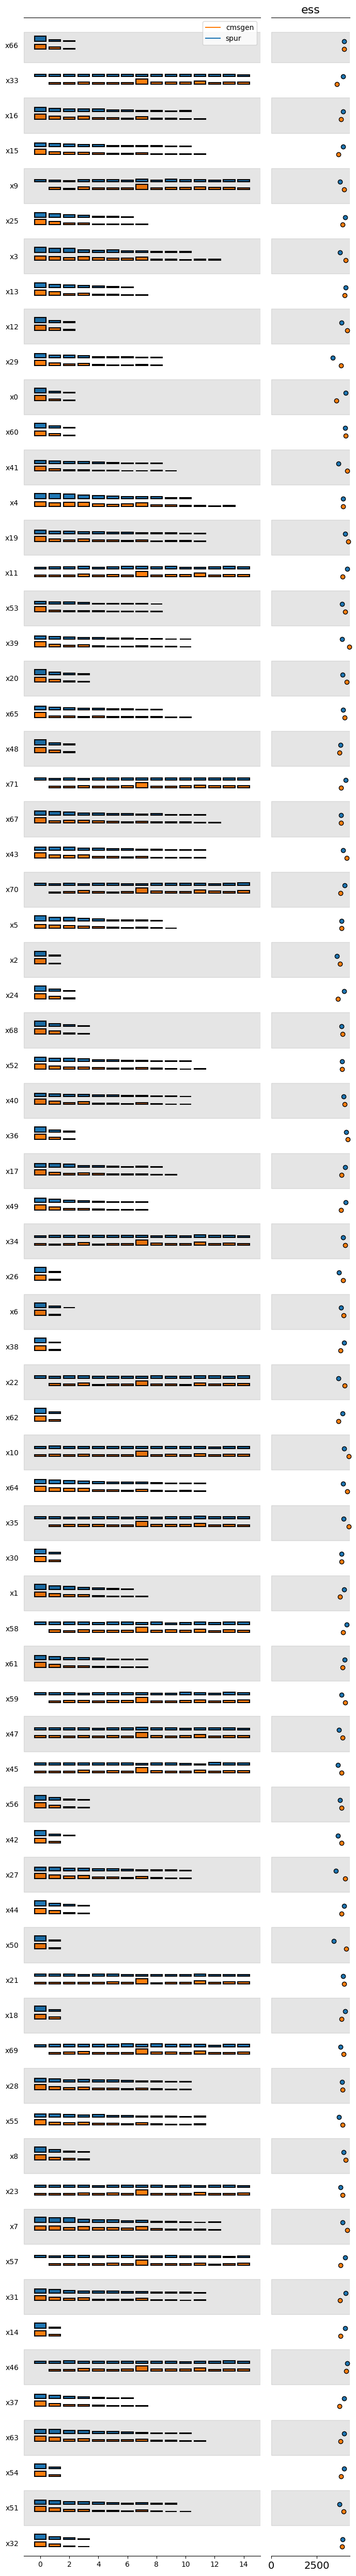

In [10]:
az.plot_forest(traces_books, combined=True, model_names=backends, hdi_prob=0.95, kind='ridgeplot', figsize=(7,50), ess=True, ridgeplot_overlap=0.5);

## Haplotypes

The experiment below considers:
* 32 Haplotypes
* 5 placings in the haplotype ($2^5 = 32$)
* 100 genotypes

First, we generate a dataset of genotypes from a set of input
haplotype probabilities. The goal of the experiments is recovering
those probabilities after sampling.

In [2]:
# config of the experiment
bits_per_haplotype = 5
num_haplotypes = 2**bits_per_haplotype
num_genotypes = 100

# list of distinct haplotypes
haplotypes = list(map(list, itertools.product([0, 1], repeat=bits_per_haplotype)))

# list of haplotypes probabilities
haplotypesProb = [
    0.0056,   0.004,                0.00368,  0.1,                 
    0.005681, 0.09,                 0.00468,  0.003,    
    0.08,     0.006147,             0.00595,  0.0071,   
    0.00345,  0.00632,              0.1,      0.0029,   
    0.0071,   0.006147,             0.085,    0.0045671,
    0.003379, 0.1,                  0.00461,  0.00614,             
    0.075,    0.08,                 0.00761,  0.004321, 
    0.09,     0.009217900000000112, 0.0134,   0.075]

# there must be a haplotype probability for each haplotype
if not (len(haplotypes) == len(haplotypesProb)):
    raise RuntimeError('The size of the list of haplotype probabilities does not match the list of distinct haplotypes')

# dict to store haplotype counts after sampling
haplotypesnumber = {}
for i in range(32):
    haplotypesnumber[str(haplotypes[i])] = 0

genotypes = []
d = {'h_1': [], 'h_2': [], 'g': []} # NOTE: added by Raúl

# seeds not working...
np.random.seed(2024)
random.seed(2024)

# we generate `num_genotypes` by sampling pairs of haplotypes according to their probabilities
for i in range(num_genotypes):
    h1 = np.random.choice(np.arange(num_haplotypes), p=haplotypesProb) # samples one haplotype (from 0 to 31) with probabilities above
    h2 = np.random.choice(np.arange(num_haplotypes), p=haplotypesProb) # samples one haplotype (from 0 to 31) with probabilities above
    genotypes.append(list(map(operator.add,haplotypes[h1],haplotypes[h2]))) # combines them to form a genotype
    d['h_1'].append(haplotypes[h1]); d['h_2'].append(haplotypes[h2]); d['g'].append(genotypes[i]); # NOTE: added by Raúl
    haplotypesnumber[str(haplotypes[h1])] = haplotypesnumber[str(haplotypes[h1])] + 1 # keeps count of sampled haplotypes 
    haplotypesnumber[str(haplotypes[h2])] = haplotypesnumber[str(haplotypes[h2])] + 1 # keeps count of sampled haplotypes 
df = pd.DataFrame(data=d)

In [3]:
df

,h_1,h_2,g
0,"[1, 0, 1, 0, 1]","[1, 1, 0, 0, 0]","[2, 1, 1, 0, 1]"
1,"[0, 0, 1, 0, 1]","[0, 0, 0, 1, 1]","[0, 0, 1, 1, 2]"
2,"[0, 0, 1, 0, 1]","[0, 0, 0, 1, 1]","[0, 0, 1, 1, 2]"
3,"[1, 1, 0, 0, 1]","[1, 1, 0, 0, 0]","[2, 2, 0, 0, 1]"
4,"[1, 0, 0, 1, 0]","[1, 0, 0, 1, 0]","[2, 0, 0, 2, 0]"
...,...,...,...
95,"[1, 0, 1, 0, 1]","[1, 1, 0, 0, 1]","[2, 1, 1, 0, 2]"
96,"[0, 1, 0, 0, 0]","[1, 0, 1, 0, 1]","[1, 1, 1, 0, 1]"
97,"[1, 1, 1, 1, 1]","[1, 1, 0, 0, 1]","[2, 2, 1, 1, 2]"
98,"[0, 1, 1, 1, 0]","[0, 1, 1, 1, 0]","[0, 2, 2, 2, 0]"


In [5]:
TIMEOUT = 60*10 # seconds (10min)

(g, num_bits, num_vars) = models.get_haplotypes_sat(
    genotypes=np.array(genotypes)
)
(s, num_vars) = models.get_haplotypes_smt(
    genotypes=np.array(genotypes)
)
backends = ['spur', 'cmsgen', 'megasampler']
# traces_haplotypes = [ 
#     mcmc.sample_mh_trace_from_z3_model(backend=backend,
#                                        z3_problem=g,
#                                        num_bits=num_bits,
#                                        num_vars=num_vars,
#                                        num_samples=1000)
#     for backend in backends ]

traces_haplotypes = [ 
    mcmc.sample_mh_trace_from_z3_model(backend=backend,
                                       z3_problem=g,
                                       num_bits=num_bits,
                                       num_vars=num_vars,
                                       timeout_sampler=TIMEOUT,
                                       num_samples=1000)
    if backend in ['spur','cmsgen']
    else mcmc.sample_mh_trace_from_z3_model(
            backend=backend,
            z3_problem=s,
            reweight_samples=True,
            timeout_sampler=TIMEOUT,
            num_samples=1000)
    for backend in backends ]

Using default filename: "spur_input/samples_z3_problem.txt"
Performing Uniform Model Sampling...
Input File:  spur_input/z3_problem.cnf
Output File: spur_input/samples_z3_problem.txt

Preprocessing ... DONE
variables (all/used/free): 	4596/4596/0
independent support size:  	0
clauses (all/long/binary/unit): 10266/4384/4524/1358
Initialize cache
Size of Cacheable Component:	56
Size of MPZ Class:	16
Maximum cache size:	960 MB

STAGE #1: Build the initial partial assignments
STAGE #1: COMPLETED building initial partial assignments
STAGE #2 - Filling in partial assignments...
Initialize cache
Size of Cacheable Component:	56
Size of MPZ Class:	16
Maximum cache size:	960 MB

Sample #1 of 1 is already a complete assignment.  Continuing...
STAGE #2 - COMPLETE




variables (total / active / free)	4596/4596/0
clauses (removed) 		10266 (0)
decisions 				238
conflicts 				0
conflict clauses (all/bin/unit) 	0/0/1358
failed literals found by implicit BCP 	 0
implicit BCP miss rate 	0%
bytes cache size     	20255444	
bytes cache (overall) 	20255444
bytes cache (infra / comps) 20234408/21036	
bytes pure comp data (curr)    5692
bytes pure comp data (overall) 5692
bytes cache with sysoverh (curr)    36416
bytes cache with sysoverh (overall) 36416
cache (stores / hits) 			240/0
cache miss rate 		100%
avg. variable count (stores / hits) 	43.2583/0


# solutions 
441711766194596082395824375185729628956870974218904739530401550323154944

# END

time: 0.196848s


Total Sampler Execution Time: 0.196848s

#START_HEADER
start_time,Mon Jul 29 17:42:19 2024
formula_file,spur_input/z3_problem.cnf
num_vars,4596
independent_support_size,0
num_clauses,10266
tot_num_models,441711766194596082395824375185729628956870974218904739530401550323154944
max_component_split_d

c CMSGen Copyright Mate Soos (soos.mate@gmail.com)
c CMSGen SHA revision 00791438b32bb387e1f6ba7c1b211d7f6595aa06
c CMSGen is MIT licensed
c CMSGen compilation env CMAKE_CXX_COMPILER = /usr/bin/c++ | CMAKE_CXX_FLAGS =  -fno-stack-protector -mtune=native -Wlogical-op -Wrestrict -Wnull-dereference -Wdouble-promotion -Wshadow -Wformat=2 -Wextra-semi -pedantic | COMPILE_DEFINES =  -DNDEBUG -D_FORTIFY_SOURCE=0 -DUSE_GAUSS -DUSE_ZLIB -DYALSAT_FPU | STATICCOMPILE = ON | ZLIB_FOUND = TRUE | VALGRIND_FOUND =  | ENABLE_TESTING = ON | SLOW_DEBUG = OFF | ENABLE_ASSERTIONS = OFF | MY_TARGETS =  | LARGEMEM =  | LIMITMEM =  | 
c CMSGen compiled with gcc version 9.4.0
c executed with command line: cmsgen --samples 1000 --samplefile cmsgen_input/cmsgen_samples.out cmsgen_input/z3_problem.cnf
c Writing samples to file: cmsgen_input/cmsgen_samples.out
c Number of samples found until now:     10
c Number of samples found until now:     20
c Number of samples found until now:     30
c Number of samples fou

c Number of samples found until now:    410
c Number of samples found until now:    420
c Number of samples found until now:    430
c Number of samples found until now:    440
c Number of samples found until now:    450
c Number of samples found until now:    460
c Number of samples found until now:    470
c Number of samples found until now:    480
c Number of samples found until now:    490
c Number of samples found until now:    500
c Number of samples found until now:    510
c Number of samples found until now:    520
c Number of samples found until now:    530
c Number of samples found until now:    540
c Number of samples found until now:    550
c Number of samples found until now:    560
c Number of samples found until now:    570
c Number of samples found until now:    580
c Number of samples found until now:    590
c Number of samples found until now:    600
c Number of samples found until now:    610
c Number of samples found until now:    620
c Number of samples found until 

c Number of samples found until now:    890
c Number of samples found until now:    900
c Number of samples found until now:    910
c Number of samples found until now:    920
c Number of samples found until now:    930
c Number of samples found until now:    940
c Number of samples found until now:    950
c Number of samples found until now:    960
c Number of samples found until now:    970
c Number of samples found until now:    980
c Number of samples found until now:    990
c Finished generating all 1000 samples
c Total time: 0.39 s 


Parsing input file: megasampler_input/z3_problem.smt2
Number of formulas in file: 2500
-------------FORMULA STATISTICS-------------
Arrays 0
Bit-vectors 0
Bools 0
Bits 0
Uninterpreted functions 0
Ints 1000
Reals 0
Formula tree depth 2
--------------------------------------------
starting MeGASampler


Formula is satisfiable
Stopping: timeout
---------SOLVING STATISTICS--------
do_epoch time: 557.736
epoch time: 600.463
grow_seed time: 15.126
initial_solving time: 0.0522206
output time: 0.124785
start_epoch time: 42.7254
total time: 600.516
Epochs: 698
MAX-SMT calls: 699
SMT calls: 0
Assignments considered (with repetitions): 71196
Models (with repetitions): 71196
Unique models (# samples in file): 1
-----------------------------------
Samples have been reweighted. The sampler generated 1 and the reweighting process has generated 1000 (according to the unnormalized posterior probability specified in the input parameter `f`).



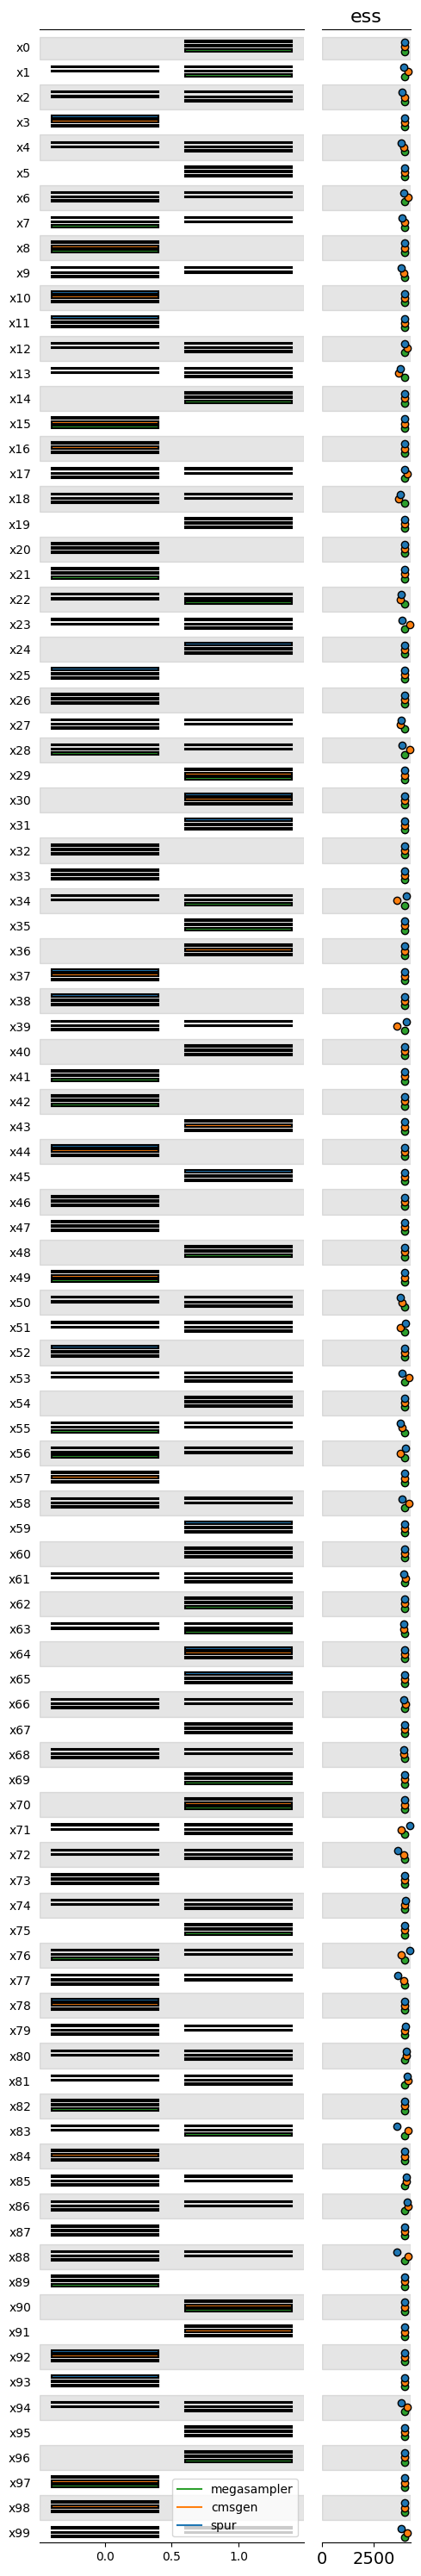

In [7]:
az.plot_forest(traces_haplotypes, combined=True, kind='ridgeplot', model_names=backends, var_names=[f'x{i}' for i in range(100)], ridgeplot_overlap=0.5,ess=True, figsize=(5,30));

In [8]:
# compare posteriors variable by variable
for var in [f'x{i}' for i in range(1000)]:
    for j in range(3):
        t = traces_haplotypes[j].posterior[var]
        print(f'{var} | mean: {t.mean().item()} | HDI: {az.hdi(t)[var].to_numpy()} | {az.ess(t)[var].to_numpy()}')
    # t = traces_haplotypes[1].posterior[var]
    # print(f'{var} | mean: {t.mean().item()} | HDI: {az.hdi(t)[var].to_numpy()} | {az.ess(t)[var].to_numpy()}')
    print('--------------')

x0 | mean: 1.0 | HDI: [1. 1.] | 4000.0
x0 | mean: 1.0 | HDI: [1. 1.] | 4000.0
x0 | mean: 1.0 | HDI: [1. 1.] | 4000.0
--------------
x1 | mean: 0.52 | HDI: [0. 1.] | 3965.051916717987
x1 | mean: 0.502 | HDI: [0. 1.] | 4176.852200178232
x1 | mean: 1.0 | HDI: [1. 1.] | 4000.0
--------------
x2 | mean: 0.506 | HDI: [0. 1.] | 3888.271760455493
x2 | mean: 0.479 | HDI: [0. 1.] | 3985.4580693777825
x2 | mean: 1.0 | HDI: [1. 1.] | 4000.0
--------------
x3 | mean: 0.0 | HDI: [0. 0.] | 4000.0
x3 | mean: 0.0 | HDI: [0. 0.] | 4000.0
x3 | mean: 0.0 | HDI: [0. 0.] | 4000.0
--------------
x4 | mean: 0.507 | HDI: [0. 1.] | 3850.191577996687
x4 | mean: 0.477 | HDI: [0. 1.] | 3960.751652290853
x4 | mean: 1.0 | HDI: [1. 1.] | 4000.0
--------------
x5 | mean: 1.0 | HDI: [1. 1.] | 4000.0
x5 | mean: 1.0 | HDI: [1. 1.] | 4000.0
x5 | mean: 1.0 | HDI: [1. 1.] | 4000.0
--------------
x6 | mean: 0.48 | HDI: [0. 1.] | 3965.051916717987
x6 | mean: 0.498 | HDI: [0. 1.] | 4176.852200178232
x6 | mean: 0.0 | HDI: [0. 0

x38 | mean: 0.0 | HDI: [0. 0.] | 4000.0
x38 | mean: 0.0 | HDI: [0. 0.] | 4000.0
x38 | mean: 0.0 | HDI: [0. 0.] | 4000.0
--------------
x39 | mean: 0.495 | HDI: [0. 1.] | 4110.082490183307
x39 | mean: 0.519 | HDI: [0. 1.] | 3624.3562037019683
x39 | mean: 0.0 | HDI: [0. 0.] | 4000.0
--------------
x40 | mean: 1.0 | HDI: [1. 1.] | 4000.0
x40 | mean: 1.0 | HDI: [1. 1.] | 4000.0
x40 | mean: 1.0 | HDI: [1. 1.] | 4000.0
--------------
x41 | mean: 0.0 | HDI: [0. 0.] | 4000.0
x41 | mean: 0.0 | HDI: [0. 0.] | 4000.0
x41 | mean: 0.0 | HDI: [0. 0.] | 4000.0
--------------
x42 | mean: 0.0 | HDI: [0. 0.] | 4000.0
x42 | mean: 0.0 | HDI: [0. 0.] | 4000.0
x42 | mean: 0.0 | HDI: [0. 0.] | 4000.0
--------------
x43 | mean: 1.0 | HDI: [1. 1.] | 4000.0
x43 | mean: 1.0 | HDI: [1. 1.] | 4000.0
x43 | mean: 1.0 | HDI: [1. 1.] | 4000.0
--------------
x44 | mean: 0.0 | HDI: [0. 0.] | 4000.0
x44 | mean: 0.0 | HDI: [0. 0.] | 4000.0
x44 | mean: 0.0 | HDI: [0. 0.] | 4000.0
--------------
x45 | mean: 1.0 | HDI: [1. 1

x75 | mean: 1.0 | HDI: [1. 1.] | 4000.0
--------------
x76 | mean: 0.462 | HDI: [0. 1.] | 4235.993416325809
x76 | mean: 0.497 | HDI: [0. 1.] | 3834.4912473394593
x76 | mean: 0.0 | HDI: [0. 0.] | 4000.0
--------------
x77 | mean: 0.506 | HDI: [0. 1.] | 3676.314086688236
x77 | mean: 0.516 | HDI: [0. 1.] | 3963.783544830095
x77 | mean: 0.0 | HDI: [0. 0.] | 4000.0
--------------
x78 | mean: 0.0 | HDI: [0. 0.] | 4000.0
x78 | mean: 0.0 | HDI: [0. 0.] | 4000.0
x78 | mean: 0.0 | HDI: [0. 0.] | 4000.0
--------------
x79 | mean: 0.462 | HDI: [0. 1.] | 4029.988326660718
x79 | mean: 0.493 | HDI: [0. 1.] | 4013.492412262022
x79 | mean: 0.0 | HDI: [0. 0.] | 4000.0
--------------
x80 | mean: 0.507 | HDI: [0. 1.] | 4119.822139585877
x80 | mean: 0.505 | HDI: [0. 1.] | 4081.368724878659
x80 | mean: 1.0 | HDI: [1. 1.] | 4000.0
--------------
x81 | mean: 0.5 | HDI: [0. 1.] | 4135.367593370583
x81 | mean: 0.501 | HDI: [0. 1.] | 4156.910832238004
x81 | mean: 1.0 | HDI: [1. 1.] | 4000.0
--------------
x82 | 

x113 | mean: 0.494 | HDI: [0. 1.] | 3941.4786173690113
x113 | mean: 0.481 | HDI: [0. 1.] | 3898.223055434328
x113 | mean: 1.0 | HDI: [1. 1.] | 4000.0
--------------
x114 | mean: 0.493 | HDI: [0. 1.] | 3942.706023404308
x114 | mean: 0.514 | HDI: [0. 1.] | 3956.540741627253
x114 | mean: 1.0 | HDI: [1. 1.] | 4000.0
--------------
x115 | mean: 0.516 | HDI: [0. 1.] | 4107.809516859324
x115 | mean: 0.496 | HDI: [0. 1.] | 3847.2397222760296
x115 | mean: 0.0 | HDI: [0. 0.] | 4000.0
--------------
x116 | mean: 1.0 | HDI: [1. 1.] | 4000.0
x116 | mean: 1.0 | HDI: [1. 1.] | 4000.0
x116 | mean: 1.0 | HDI: [1. 1.] | 4000.0
--------------
x117 | mean: 0.48 | HDI: [0. 1.] | 3970.4194021407443
x117 | mean: 0.483 | HDI: [0. 1.] | 3747.3101815694295
x117 | mean: 0.0 | HDI: [0. 0.] | 4000.0
--------------
x118 | mean: 0.506 | HDI: [0. 1.] | 3941.4786173690113
x118 | mean: 0.519 | HDI: [0. 1.] | 3898.223055434328
x118 | mean: 0.0 | HDI: [0. 0.] | 4000.0
--------------
x119 | mean: 0.507 | HDI: [0. 1.] | 39

x150 | mean: 1.0 | HDI: [1. 1.] | 4000.0
--------------
x151 | mean: 1.0 | HDI: [1. 1.] | 4000.0
x151 | mean: 1.0 | HDI: [1. 1.] | 4000.0
x151 | mean: 1.0 | HDI: [1. 1.] | 4000.0
--------------
x152 | mean: 0.0 | HDI: [0. 0.] | 4000.0
x152 | mean: 0.0 | HDI: [0. 0.] | 4000.0
x152 | mean: 0.0 | HDI: [0. 0.] | 4000.0
--------------
x153 | mean: 0.0 | HDI: [0. 0.] | 4000.0
x153 | mean: 0.0 | HDI: [0. 0.] | 4000.0
x153 | mean: 0.0 | HDI: [0. 0.] | 4000.0
--------------
x154 | mean: 0.486 | HDI: [0. 1.] | 3874.1438913240754
x154 | mean: 0.518 | HDI: [0. 1.] | 3969.9048918801736
x154 | mean: 1.0 | HDI: [1. 1.] | 4000.0
--------------
x155 | mean: 0.511 | HDI: [0. 1.] | 4003.492650863585
x155 | mean: 0.514 | HDI: [0. 1.] | 3819.2422448294114
x155 | mean: 0.0 | HDI: [0. 0.] | 4000.0
--------------
x156 | mean: 1.0 | HDI: [1. 1.] | 4000.0
x156 | mean: 1.0 | HDI: [1. 1.] | 4000.0
x156 | mean: 1.0 | HDI: [1. 1.] | 4000.0
--------------
x157 | mean: 0.0 | HDI: [0. 0.] | 4000.0
x157 | mean: 0.0 | H

x188 | mean: 0.0 | HDI: [0. 0.] | 4000.0
x188 | mean: 0.0 | HDI: [0. 0.] | 4000.0
x188 | mean: 0.0 | HDI: [0. 0.] | 4000.0
--------------
x189 | mean: 1.0 | HDI: [1. 1.] | 4000.0
x189 | mean: 1.0 | HDI: [1. 1.] | 4000.0
x189 | mean: 1.0 | HDI: [1. 1.] | 4000.0
--------------
x190 | mean: 0.0 | HDI: [0. 0.] | 4000.0
x190 | mean: 0.0 | HDI: [0. 0.] | 4000.0
x190 | mean: 0.0 | HDI: [0. 0.] | 4000.0
--------------
x191 | mean: 1.0 | HDI: [1. 1.] | 4000.0
x191 | mean: 1.0 | HDI: [1. 1.] | 4000.0
x191 | mean: 1.0 | HDI: [1. 1.] | 4000.0
--------------
x192 | mean: 0.525 | HDI: [0. 1.] | 3980.5390101406174
x192 | mean: 0.492 | HDI: [0. 1.] | 3438.7510047510245
x192 | mean: 1.0 | HDI: [1. 1.] | 4000.0
--------------
x193 | mean: 0.495 | HDI: [0. 1.] | 3919.079644691825
x193 | mean: 0.479 | HDI: [0. 1.] | 3927.2850692927695
x193 | mean: 1.0 | HDI: [1. 1.] | 4000.0
--------------
x194 | mean: 0.0 | HDI: [0. 0.] | 4000.0
x194 | mean: 0.0 | HDI: [0. 0.] | 4000.0
x194 | mean: 0.0 | HDI: [0. 0.] | 4

x225 | mean: 0.0 | HDI: [0. 0.] | 4000.0
--------------
x226 | mean: 0.535 | HDI: [0. 1.] | 4102.712115384404
x226 | mean: 0.481 | HDI: [0. 1.] | 4156.231021350591
x226 | mean: 0.0 | HDI: [0. 0.] | 4000.0
--------------
x227 | mean: 1.0 | HDI: [1. 1.] | 4000.0
x227 | mean: 1.0 | HDI: [1. 1.] | 4000.0
x227 | mean: 1.0 | HDI: [1. 1.] | 4000.0
--------------
x228 | mean: 0.0 | HDI: [0. 0.] | 4000.0
x228 | mean: 0.0 | HDI: [0. 0.] | 4000.0
x228 | mean: 0.0 | HDI: [0. 0.] | 4000.0
--------------
x229 | mean: 0.52 | HDI: [0. 1.] | 4016.0857382476597
x229 | mean: 0.51 | HDI: [0. 1.] | 3993.895877477106
x229 | mean: 0.0 | HDI: [0. 0.] | 4000.0
--------------
x230 | mean: 1.0 | HDI: [1. 1.] | 4000.0
x230 | mean: 1.0 | HDI: [1. 1.] | 4000.0
x230 | mean: 1.0 | HDI: [1. 1.] | 4000.0
--------------
x231 | mean: 0.488 | HDI: [0. 1.] | 4044.8676677385797
x231 | mean: 0.529 | HDI: [0. 1.] | 4130.080373726287
x231 | mean: 1.0 | HDI: [1. 1.] | 4000.0
--------------
x232 | mean: 0.486 | HDI: [0. 1.] | 43

x263 | mean: 1.0 | HDI: [1. 1.] | 4000.0
x263 | mean: 1.0 | HDI: [1. 1.] | 4000.0
x263 | mean: 1.0 | HDI: [1. 1.] | 4000.0
--------------
x264 | mean: 0.505 | HDI: [0. 1.] | 4301.654061085157
x264 | mean: 0.495 | HDI: [0. 1.] | 3330.487903154641
x264 | mean: 1.0 | HDI: [1. 1.] | 4000.0
--------------
x265 | mean: 1.0 | HDI: [1. 1.] | 4000.0
x265 | mean: 1.0 | HDI: [1. 1.] | 4000.0
x265 | mean: 1.0 | HDI: [1. 1.] | 4000.0
--------------
x266 | mean: 0.517 | HDI: [0. 1.] | 3785.051467347175
x266 | mean: 0.485 | HDI: [0. 1.] | 3731.3505153299675
x266 | mean: 0.0 | HDI: [0. 0.] | 4000.0
--------------
x267 | mean: 0.471 | HDI: [0. 1.] | 4023.7271263459656
x267 | mean: 0.504 | HDI: [0. 1.] | 4227.220414418111
x267 | mean: 0.0 | HDI: [0. 0.] | 4000.0
--------------
x268 | mean: 1.0 | HDI: [1. 1.] | 4000.0
x268 | mean: 1.0 | HDI: [1. 1.] | 4000.0
x268 | mean: 1.0 | HDI: [1. 1.] | 4000.0
--------------
x269 | mean: 0.495 | HDI: [0. 1.] | 4301.654061085157
x269 | mean: 0.505 | HDI: [0. 1.] | 33

x301 | mean: 1.0 | HDI: [1. 1.] | 4000.0
x301 | mean: 1.0 | HDI: [1. 1.] | 4000.0
x301 | mean: 1.0 | HDI: [1. 1.] | 4000.0
--------------
x302 | mean: 0.51 | HDI: [0. 1.] | 3628.635422707022
x302 | mean: 0.52 | HDI: [0. 1.] | 3956.800267234086
x302 | mean: 1.0 | HDI: [1. 1.] | 4000.0
--------------
x303 | mean: 1.0 | HDI: [1. 1.] | 4000.0
x303 | mean: 1.0 | HDI: [1. 1.] | 4000.0
x303 | mean: 1.0 | HDI: [1. 1.] | 4000.0
--------------
x304 | mean: 0.481 | HDI: [0. 1.] | 3940.298649552678
x304 | mean: 0.482 | HDI: [0. 1.] | 3446.220997563215
x304 | mean: 1.0 | HDI: [1. 1.] | 4000.0
--------------
x305 | mean: 0.0 | HDI: [0. 0.] | 4000.0
x305 | mean: 0.0 | HDI: [0. 0.] | 4000.0
x305 | mean: 0.0 | HDI: [0. 0.] | 4000.0
--------------
x306 | mean: 1.0 | HDI: [1. 1.] | 4000.0
x306 | mean: 1.0 | HDI: [1. 1.] | 4000.0
x306 | mean: 1.0 | HDI: [1. 1.] | 4000.0
--------------
x307 | mean: 0.49 | HDI: [0. 1.] | 3628.635422707022
x307 | mean: 0.48 | HDI: [0. 1.] | 3956.800267234086
x307 | mean: 0.0

x338 | mean: 0.0 | HDI: [0. 0.] | 4000.0
--------------
x339 | mean: 0.488 | HDI: [0. 1.] | 3532.512932338728
x339 | mean: 0.495 | HDI: [0. 1.] | 3820.637081614877
x339 | mean: 0.0 | HDI: [0. 0.] | 4000.0
--------------
x340 | mean: 0.488 | HDI: [0. 1.] | 4052.8053591627045
x340 | mean: 0.522 | HDI: [0. 1.] | 3948.704034784954
x340 | mean: 1.0 | HDI: [1. 1.] | 4000.0
--------------
x341 | mean: 1.0 | HDI: [1. 1.] | 4000.0
x341 | mean: 1.0 | HDI: [1. 1.] | 4000.0
x341 | mean: 1.0 | HDI: [1. 1.] | 4000.0
--------------
x342 | mean: 0.488 | HDI: [0. 1.] | 3830.3477507518874
x342 | mean: 0.508 | HDI: [0. 1.] | 3907.586399412779
x342 | mean: 1.0 | HDI: [1. 1.] | 4000.0
--------------
x343 | mean: 0.515 | HDI: [0. 1.] | 3986.539360768919
x343 | mean: 0.469 | HDI: [0. 1.] | 3524.5311695652726
x343 | mean: 1.0 | HDI: [1. 1.] | 4000.0
--------------
x344 | mean: 0.529 | HDI: [0. 1.] | 3880.3939402097535
x344 | mean: 0.489 | HDI: [0. 1.] | 4007.8232572365064
x344 | mean: 1.0 | HDI: [1. 1.] | 400

x374 | mean: 0.0 | HDI: [0. 0.] | 4000.0
x374 | mean: 0.0 | HDI: [0. 0.] | 4000.0
--------------
x375 | mean: 0.499 | HDI: [0. 1.] | 3970.1304484164534
x375 | mean: 0.507 | HDI: [0. 1.] | 3973.1018007896955
x375 | mean: 0.0 | HDI: [0. 0.] | 4000.0
--------------
x376 | mean: 1.0 | HDI: [1. 1.] | 4000.0
x376 | mean: 1.0 | HDI: [1. 1.] | 4000.0
x376 | mean: 1.0 | HDI: [1. 1.] | 4000.0
--------------
x377 | mean: 0.503 | HDI: [0. 1.] | 3924.7948273969087
x377 | mean: 0.486 | HDI: [0. 1.] | 4097.593041560251
x377 | mean: 0.0 | HDI: [0. 0.] | 4000.0
--------------
x378 | mean: 0.513 | HDI: [0. 1.] | 3448.4301442650826
x378 | mean: 0.487 | HDI: [0. 1.] | 4053.9973930373553
x378 | mean: 0.0 | HDI: [0. 0.] | 4000.0
--------------
x379 | mean: 0.0 | HDI: [0. 0.] | 4000.0
x379 | mean: 0.0 | HDI: [0. 0.] | 4000.0
x379 | mean: 0.0 | HDI: [0. 0.] | 4000.0
--------------
x380 | mean: 0.488 | HDI: [0. 1.] | 3879.4135997862554
x380 | mean: 0.478 | HDI: [0. 1.] | 4137.58438685234
x380 | mean: 1.0 | HDI

x411 | mean: 1.0 | HDI: [1. 1.] | 4000.0
--------------
x412 | mean: 0.512 | HDI: [0. 1.] | 3943.6506447114994
x412 | mean: 0.479 | HDI: [0. 1.] | 3807.2697880845185
x412 | mean: 1.0 | HDI: [1. 1.] | 4000.0
--------------
x413 | mean: 0.0 | HDI: [0. 0.] | 4000.0
x413 | mean: 0.0 | HDI: [0. 0.] | 4000.0
x413 | mean: 0.0 | HDI: [0. 0.] | 4000.0
--------------
x414 | mean: 1.0 | HDI: [1. 1.] | 4000.0
x414 | mean: 1.0 | HDI: [1. 1.] | 4000.0
x414 | mean: 1.0 | HDI: [1. 1.] | 4000.0
--------------
x415 | mean: 0.497 | HDI: [0. 1.] | 3761.0889815454275
x415 | mean: 0.508 | HDI: [0. 1.] | 4078.7718520771186
x415 | mean: 0.0 | HDI: [0. 0.] | 4000.0
--------------
x416 | mean: 0.498 | HDI: [0. 1.] | 3757.1353968623353
x416 | mean: 0.512 | HDI: [0. 1.] | 3918.835326274418
x416 | mean: 0.0 | HDI: [0. 0.] | 4000.0
--------------
x417 | mean: 0.488 | HDI: [0. 1.] | 3943.6506447115034
x417 | mean: 0.521 | HDI: [0. 1.] | 3807.2697880845185
x417 | mean: 0.0 | HDI: [0. 0.] | 4000.0
--------------
x418 

x449 | mean: 0.479 | HDI: [0. 1.] | 4317.321449897968
x449 | mean: 0.0 | HDI: [0. 0.] | 4000.0
--------------
x450 | mean: 0.486 | HDI: [0. 1.] | 4075.1257357329964
x450 | mean: 0.504 | HDI: [0. 1.] | 4305.804400825847
x450 | mean: 1.0 | HDI: [1. 1.] | 4000.0
--------------
x451 | mean: 0.525 | HDI: [0. 1.] | 3626.4386078375105
x451 | mean: 0.506 | HDI: [0. 1.] | 3992.5054119489423
x451 | mean: 1.0 | HDI: [1. 1.] | 4000.0
--------------
x452 | mean: 1.0 | HDI: [1. 1.] | 4000.0
x452 | mean: 1.0 | HDI: [1. 1.] | 4000.0
x452 | mean: 1.0 | HDI: [1. 1.] | 4000.0
--------------
x453 | mean: 1.0 | HDI: [1. 1.] | 4000.0
x453 | mean: 1.0 | HDI: [1. 1.] | 4000.0
x453 | mean: 1.0 | HDI: [1. 1.] | 4000.0
--------------
x454 | mean: 0.0 | HDI: [0. 0.] | 4000.0
x454 | mean: 0.0 | HDI: [0. 0.] | 4000.0
x454 | mean: 0.0 | HDI: [0. 0.] | 4000.0
--------------
x455 | mean: 0.514 | HDI: [0. 1.] | 4075.1257357329964
x455 | mean: 0.496 | HDI: [0. 1.] | 4305.804400825847
x455 | mean: 0.0 | HDI: [0. 0.] | 40

x486 | mean: 0.0 | HDI: [0. 0.] | 4000.0
--------------
x487 | mean: 1.0 | HDI: [1. 1.] | 4000.0
x487 | mean: 1.0 | HDI: [1. 1.] | 4000.0
x487 | mean: 1.0 | HDI: [1. 1.] | 4000.0
--------------
x488 | mean: 0.0 | HDI: [0. 0.] | 4000.0
x488 | mean: 0.0 | HDI: [0. 0.] | 4000.0
x488 | mean: 0.0 | HDI: [0. 0.] | 4000.0
--------------
x489 | mean: 0.522 | HDI: [0. 1.] | 3625.7219502094486
x489 | mean: 0.507 | HDI: [0. 1.] | 3723.0803265473182
x489 | mean: 0.0 | HDI: [0. 0.] | 4000.0
--------------
x490 | mean: 0.509 | HDI: [0. 1.] | 3966.1189325195796
x490 | mean: 0.506 | HDI: [0. 1.] | 3932.4659973980683
x490 | mean: 1.0 | HDI: [1. 1.] | 4000.0
--------------
x491 | mean: 0.517 | HDI: [0. 1.] | 4061.878803770061
x491 | mean: 0.505 | HDI: [0. 1.] | 3945.2631625872486
x491 | mean: 1.0 | HDI: [1. 1.] | 4000.0
--------------
x492 | mean: 0.52 | HDI: [0. 1.] | 4040.70883686262
x492 | mean: 0.496 | HDI: [0. 1.] | 4068.886150295152
x492 | mean: 1.0 | HDI: [1. 1.] | 4000.0
--------------
x493 | me

x524 | mean: 1.0 | HDI: [1. 1.] | 4000.0
x524 | mean: 1.0 | HDI: [1. 1.] | 4000.0
--------------
x525 | mean: 0.488 | HDI: [0. 1.] | 3996.5610865646318
x525 | mean: 0.455 | HDI: [0. 1.] | 3810.126863033629
x525 | mean: 0.0 | HDI: [0. 0.] | 4000.0
--------------
x526 | mean: 0.487 | HDI: [0. 1.] | 3673.1698716045107
x526 | mean: 0.481 | HDI: [0. 1.] | 3514.481914276737
x526 | mean: 0.0 | HDI: [0. 0.] | 4000.0
--------------
x527 | mean: 0.515 | HDI: [0. 1.] | 4021.5458647016385
x527 | mean: 0.482 | HDI: [0. 1.] | 4050.694129550758
x527 | mean: 0.0 | HDI: [0. 0.] | 4000.0
--------------
x528 | mean: 0.0 | HDI: [0. 0.] | 4000.0
x528 | mean: 0.0 | HDI: [0. 0.] | 4000.0
x528 | mean: 0.0 | HDI: [0. 0.] | 4000.0
--------------
x529 | mean: 1.0 | HDI: [1. 1.] | 4000.0
x529 | mean: 1.0 | HDI: [1. 1.] | 4000.0
x529 | mean: 1.0 | HDI: [1. 1.] | 4000.0
--------------
x530 | mean: 1.0 | HDI: [1. 1.] | 4000.0
x530 | mean: 1.0 | HDI: [1. 1.] | 4000.0
x530 | mean: 1.0 | HDI: [1. 1.] | 4000.0
---------

x561 | mean: 0.526 | HDI: [0. 1.] | 3918.5911856655907
x561 | mean: 1.0 | HDI: [1. 1.] | 4000.0
--------------
x562 | mean: 0.485 | HDI: [0. 1.] | 4063.161832081879
x562 | mean: 0.506 | HDI: [0. 1.] | 3969.7086094771885
x562 | mean: 1.0 | HDI: [1. 1.] | 4000.0
--------------
x563 | mean: 1.0 | HDI: [1. 1.] | 4000.0
x563 | mean: 1.0 | HDI: [1. 1.] | 4000.0
x563 | mean: 1.0 | HDI: [1. 1.] | 4000.0
--------------
x564 | mean: 1.0 | HDI: [1. 1.] | 4000.0
x564 | mean: 1.0 | HDI: [1. 1.] | 4000.0
x564 | mean: 1.0 | HDI: [1. 1.] | 4000.0
--------------
x565 | mean: 0.507 | HDI: [0. 1.] | 4043.911361792482
x565 | mean: 0.497 | HDI: [0. 1.] | 3974.9956624835695
x565 | mean: 0.0 | HDI: [0. 0.] | 4000.0
--------------
x566 | mean: 0.511 | HDI: [0. 1.] | 3987.0772382642303
x566 | mean: 0.474 | HDI: [0. 1.] | 3918.5911856655907
x566 | mean: 0.0 | HDI: [0. 0.] | 4000.0
--------------
x567 | mean: 0.515 | HDI: [0. 1.] | 4063.161832081879
x567 | mean: 0.494 | HDI: [0. 1.] | 3969.7086094771903
x567 | m

x599 | mean: 0.498 | HDI: [0. 1.] | 4190.377386879494
x599 | mean: 0.467 | HDI: [0. 1.] | 3919.781654077062
x599 | mean: 0.0 | HDI: [0. 0.] | 4000.0
--------------
x600 | mean: 1.0 | HDI: [1. 1.] | 4000.0
x600 | mean: 1.0 | HDI: [1. 1.] | 4000.0
x600 | mean: 1.0 | HDI: [1. 1.] | 4000.0
--------------
x601 | mean: 1.0 | HDI: [1. 1.] | 4000.0
x601 | mean: 1.0 | HDI: [1. 1.] | 4000.0
x601 | mean: 1.0 | HDI: [1. 1.] | 4000.0
--------------
x602 | mean: 1.0 | HDI: [1. 1.] | 4000.0
x602 | mean: 1.0 | HDI: [1. 1.] | 4000.0
x602 | mean: 1.0 | HDI: [1. 1.] | 4000.0
--------------
x603 | mean: 0.0 | HDI: [0. 0.] | 4000.0
x603 | mean: 0.0 | HDI: [0. 0.] | 4000.0
x603 | mean: 0.0 | HDI: [0. 0.] | 4000.0
--------------
x604 | mean: 0.0 | HDI: [0. 0.] | 4000.0
x604 | mean: 0.0 | HDI: [0. 0.] | 4000.0
x604 | mean: 0.0 | HDI: [0. 0.] | 4000.0
--------------
x605 | mean: 1.0 | HDI: [1. 1.] | 4000.0
x605 | mean: 1.0 | HDI: [1. 1.] | 4000.0
x605 | mean: 1.0 | HDI: [1. 1.] | 4000.0
--------------
x606 | m

x636 | mean: 1.0 | HDI: [1. 1.] | 4000.0
--------------
x637 | mean: 0.499 | HDI: [0. 1.] | 4009.081498239797
x637 | mean: 0.532 | HDI: [0. 1.] | 4017.6842470543693
x637 | mean: 0.0 | HDI: [0. 0.] | 4000.0
--------------
x638 | mean: 0.492 | HDI: [0. 1.] | 3789.2133954374176
x638 | mean: 0.525 | HDI: [0. 1.] | 4223.48638052724
x638 | mean: 0.0 | HDI: [0. 0.] | 4000.0
--------------
x639 | mean: 0.489 | HDI: [0. 1.] | 4026.9758553998486
x639 | mean: 0.502 | HDI: [0. 1.] | 3944.589259452382
x639 | mean: 0.0 | HDI: [0. 0.] | 4000.0
--------------
x640 | mean: 0.0 | HDI: [0. 0.] | 4000.0
x640 | mean: 0.0 | HDI: [0. 0.] | 4000.0
x640 | mean: 0.0 | HDI: [0. 0.] | 4000.0
--------------
x641 | mean: 1.0 | HDI: [1. 1.] | 4000.0
x641 | mean: 1.0 | HDI: [1. 1.] | 4000.0
x641 | mean: 1.0 | HDI: [1. 1.] | 4000.0
--------------
x642 | mean: 0.481 | HDI: [0. 1.] | 4176.181556837169
x642 | mean: 0.49 | HDI: [0. 1.] | 4084.052818433371
x642 | mean: 1.0 | HDI: [1. 1.] | 4000.0
--------------
x643 | mean

x673 | mean: 1.0 | HDI: [1. 1.] | 4000.0
--------------
x674 | mean: 0.512 | HDI: [0. 1.] | 3840.712913757852
x674 | mean: 0.5 | HDI: [0. 1.] | 3607.2055794025273
x674 | mean: 1.0 | HDI: [1. 1.] | 4000.0
--------------
x675 | mean: 1.0 | HDI: [1. 1.] | 4000.0
x675 | mean: 1.0 | HDI: [1. 1.] | 4000.0
x675 | mean: 1.0 | HDI: [1. 1.] | 4000.0
--------------
x676 | mean: 0.495 | HDI: [0. 1.] | 3959.9006068943227
x676 | mean: 0.482 | HDI: [0. 1.] | 3930.602727409621
x676 | mean: 0.0 | HDI: [0. 0.] | 4000.0
--------------
x677 | mean: 0.484 | HDI: [0. 1.] | 3716.727220601721
x677 | mean: 0.494 | HDI: [0. 1.] | 3984.704404559498
x677 | mean: 0.0 | HDI: [0. 0.] | 4000.0
--------------
x678 | mean: 0.522 | HDI: [0. 1.] | 4145.328715755081
x678 | mean: 0.493 | HDI: [0. 1.] | 4024.956760461769
x678 | mean: 0.0 | HDI: [0. 0.] | 4000.0
--------------
x679 | mean: 0.488 | HDI: [0. 1.] | 3840.712913757852
x679 | mean: 0.5 | HDI: [0. 1.] | 3607.2055794025273
x679 | mean: 0.0 | HDI: [0. 0.] | 4000.0
--

x710 | mean: 1.0 | HDI: [1. 1.] | 4000.0
x710 | mean: 1.0 | HDI: [1. 1.] | 4000.0
--------------
x711 | mean: 0.499 | HDI: [0. 1.] | 3849.834319037134
x711 | mean: 0.507 | HDI: [0. 1.] | 3889.304108395145
x711 | mean: 1.0 | HDI: [1. 1.] | 4000.0
--------------
x712 | mean: 0.0 | HDI: [0. 0.] | 4000.0
x712 | mean: 0.0 | HDI: [0. 0.] | 4000.0
x712 | mean: 0.0 | HDI: [0. 0.] | 4000.0
--------------
x713 | mean: 0.49 | HDI: [0. 1.] | 3899.070952082591
x713 | mean: 0.509 | HDI: [0. 1.] | 3919.8079834862956
x713 | mean: 1.0 | HDI: [1. 1.] | 4000.0
--------------
x714 | mean: 0.0 | HDI: [0. 0.] | 4000.0
x714 | mean: 0.0 | HDI: [0. 0.] | 4000.0
x714 | mean: 0.0 | HDI: [0. 0.] | 4000.0
--------------
x715 | mean: 1.0 | HDI: [1. 1.] | 4000.0
x715 | mean: 1.0 | HDI: [1. 1.] | 4000.0
x715 | mean: 1.0 | HDI: [1. 1.] | 4000.0
--------------
x716 | mean: 0.501 | HDI: [0. 1.] | 3849.834319037134
x716 | mean: 0.493 | HDI: [0. 1.] | 3889.304108395145
x716 | mean: 0.0 | HDI: [0. 0.] | 4000.0
------------

x748 | mean: 0.523 | HDI: [0. 1.] | 4115.077167035949
x748 | mean: 0.512 | HDI: [0. 1.] | 3910.3538968941925
x748 | mean: 0.0 | HDI: [0. 0.] | 4000.0
--------------
x749 | mean: 0.0 | HDI: [0. 0.] | 4000.0
x749 | mean: 0.0 | HDI: [0. 0.] | 4000.0
x749 | mean: 0.0 | HDI: [0. 0.] | 4000.0
--------------
x750 | mean: 0.525 | HDI: [0. 1.] | 3914.3569012097796
x750 | mean: 0.527 | HDI: [0. 1.] | 4020.490531036469
x750 | mean: 1.0 | HDI: [1. 1.] | 4000.0
--------------
x751 | mean: 1.0 | HDI: [1. 1.] | 4000.0
x751 | mean: 1.0 | HDI: [1. 1.] | 4000.0
x751 | mean: 1.0 | HDI: [1. 1.] | 4000.0
--------------
x752 | mean: 0.493 | HDI: [0. 1.] | 3952.884433847463
x752 | mean: 0.511 | HDI: [0. 1.] | 3708.922854401432
x752 | mean: 1.0 | HDI: [1. 1.] | 4000.0
--------------
x753 | mean: 0.0 | HDI: [0. 0.] | 4000.0
x753 | mean: 0.0 | HDI: [0. 0.] | 4000.0
x753 | mean: 0.0 | HDI: [0. 0.] | 4000.0
--------------
x754 | mean: 0.0 | HDI: [0. 0.] | 4000.0
x754 | mean: 0.0 | HDI: [0. 0.] | 4000.0
x754 | mea

x786 | mean: 0.502 | HDI: [0. 1.] | 3988.033613028419
x786 | mean: 0.481 | HDI: [0. 1.] | 4232.0217477087535
x786 | mean: 0.0 | HDI: [0. 0.] | 4000.0
--------------
x787 | mean: 0.498 | HDI: [0. 1.] | 4121.886400171193
x787 | mean: 0.53 | HDI: [0. 1.] | 3933.5318828499903
x787 | mean: 0.0 | HDI: [0. 0.] | 4000.0
--------------
x788 | mean: 1.0 | HDI: [1. 1.] | 4000.0
x788 | mean: 1.0 | HDI: [1. 1.] | 4000.0
x788 | mean: 1.0 | HDI: [1. 1.] | 4000.0
--------------
x789 | mean: 0.522 | HDI: [0. 1.] | 4098.774896023392
x789 | mean: 0.499 | HDI: [0. 1.] | 3853.2195345390805
x789 | mean: 0.0 | HDI: [0. 0.] | 4000.0
--------------
x790 | mean: 1.0 | HDI: [1. 1.] | 4000.0
x790 | mean: 1.0 | HDI: [1. 1.] | 4000.0
x790 | mean: 1.0 | HDI: [1. 1.] | 4000.0
--------------
x791 | mean: 0.0 | HDI: [0. 0.] | 4000.0
x791 | mean: 0.0 | HDI: [0. 0.] | 4000.0
x791 | mean: 0.0 | HDI: [0. 0.] | 4000.0
--------------
x792 | mean: 0.0 | HDI: [0. 0.] | 4000.0
x792 | mean: 0.0 | HDI: [0. 0.] | 4000.0
x792 | mea

x824 | mean: 0.503 | HDI: [0. 1.] | 3871.5306565098563
x824 | mean: 0.515 | HDI: [0. 1.] | 3389.17719095187
x824 | mean: 1.0 | HDI: [1. 1.] | 4000.0
--------------
x825 | mean: 1.0 | HDI: [1. 1.] | 4000.0
x825 | mean: 1.0 | HDI: [1. 1.] | 4000.0
x825 | mean: 1.0 | HDI: [1. 1.] | 4000.0
--------------
x826 | mean: 1.0 | HDI: [1. 1.] | 4000.0
x826 | mean: 1.0 | HDI: [1. 1.] | 4000.0
x826 | mean: 1.0 | HDI: [1. 1.] | 4000.0
--------------
x827 | mean: 0.0 | HDI: [0. 0.] | 4000.0
x827 | mean: 0.0 | HDI: [0. 0.] | 4000.0
x827 | mean: 0.0 | HDI: [0. 0.] | 4000.0
--------------
x828 | mean: 0.0 | HDI: [0. 0.] | 4000.0
x828 | mean: 0.0 | HDI: [0. 0.] | 4000.0
x828 | mean: 0.0 | HDI: [0. 0.] | 4000.0
--------------
x829 | mean: 0.497 | HDI: [0. 1.] | 3871.5306565098563
x829 | mean: 0.485 | HDI: [0. 1.] | 3389.17719095187
x829 | mean: 0.0 | HDI: [0. 0.] | 4000.0
--------------
x830 | mean: 1.0 | HDI: [1. 1.] | 4000.0
x830 | mean: 1.0 | HDI: [1. 1.] | 4000.0
x830 | mean: 1.0 | HDI: [1. 1.] | 4000

x860 | mean: 1.0 | HDI: [1. 1.] | 4000.0
--------------
x861 | mean: 1.0 | HDI: [1. 1.] | 4000.0
x861 | mean: 1.0 | HDI: [1. 1.] | 4000.0
x861 | mean: 1.0 | HDI: [1. 1.] | 4000.0
--------------
x862 | mean: 0.502 | HDI: [0. 1.] | 4113.323430438713
x862 | mean: 0.504 | HDI: [0. 1.] | 3279.102163459976
x862 | mean: 1.0 | HDI: [1. 1.] | 4000.0
--------------
x863 | mean: 0.0 | HDI: [0. 0.] | 4000.0
x863 | mean: 0.0 | HDI: [0. 0.] | 4000.0
x863 | mean: 0.0 | HDI: [0. 0.] | 4000.0
--------------
x864 | mean: 0.497 | HDI: [0. 1.] | 3864.3421120915395
x864 | mean: 0.502 | HDI: [0. 1.] | 3928.236076926336
x864 | mean: 1.0 | HDI: [1. 1.] | 4000.0
--------------
x865 | mean: 1.0 | HDI: [1. 1.] | 4000.0
x865 | mean: 1.0 | HDI: [1. 1.] | 4000.0
x865 | mean: 1.0 | HDI: [1. 1.] | 4000.0
--------------
x866 | mean: 1.0 | HDI: [1. 1.] | 4000.0
x866 | mean: 1.0 | HDI: [1. 1.] | 4000.0
x866 | mean: 1.0 | HDI: [1. 1.] | 4000.0
--------------
x867 | mean: 0.498 | HDI: [0. 1.] | 4113.323430438713
x867 | me

x898 | mean: 0.0 | HDI: [0. 0.] | 4000.0
--------------
x899 | mean: 0.53 | HDI: [0. 1.] | 4102.450990199278
x899 | mean: 0.527 | HDI: [0. 1.] | 4332.103910967192
x899 | mean: 0.0 | HDI: [0. 0.] | 4000.0
--------------
x900 | mean: 1.0 | HDI: [1. 1.] | 4000.0
x900 | mean: 1.0 | HDI: [1. 1.] | 4000.0
x900 | mean: 1.0 | HDI: [1. 1.] | 4000.0
--------------
x901 | mean: 1.0 | HDI: [1. 1.] | 4000.0
x901 | mean: 1.0 | HDI: [1. 1.] | 4000.0
x901 | mean: 1.0 | HDI: [1. 1.] | 4000.0
--------------
x902 | mean: 1.0 | HDI: [1. 1.] | 4000.0
x902 | mean: 1.0 | HDI: [1. 1.] | 4000.0
x902 | mean: 1.0 | HDI: [1. 1.] | 4000.0
--------------
x903 | mean: 0.497 | HDI: [0. 1.] | 3942.3705527601273
x903 | mean: 0.509 | HDI: [0. 1.] | 3894.3850980462616
x903 | mean: 1.0 | HDI: [1. 1.] | 4000.0
--------------
x904 | mean: 0.0 | HDI: [0. 0.] | 4000.0
x904 | mean: 0.0 | HDI: [0. 0.] | 4000.0
x904 | mean: 0.0 | HDI: [0. 0.] | 4000.0
--------------
x905 | mean: 1.0 | HDI: [1. 1.] | 4000.0
x905 | mean: 1.0 | HDI

x936 | mean: 0.0 | HDI: [0. 0.] | 4000.0
x936 | mean: 0.0 | HDI: [0. 0.] | 4000.0
--------------
x937 | mean: 0.496 | HDI: [0. 1.] | 3922.733542881016
x937 | mean: 0.5 | HDI: [0. 1.] | 3715.214684217859
x937 | mean: 0.0 | HDI: [0. 0.] | 4000.0
--------------
x938 | mean: 0.507 | HDI: [0. 1.] | 4088.5324796405794
x938 | mean: 0.514 | HDI: [0. 1.] | 3552.2071562332617
x938 | mean: 0.0 | HDI: [0. 0.] | 4000.0
--------------
x939 | mean: 1.0 | HDI: [1. 1.] | 4000.0
x939 | mean: 1.0 | HDI: [1. 1.] | 4000.0
x939 | mean: 1.0 | HDI: [1. 1.] | 4000.0
--------------
x940 | mean: 0.529 | HDI: [0. 1.] | 4112.047161959991
x940 | mean: 0.503 | HDI: [0. 1.] | 3939.2217685420405
x940 | mean: 1.0 | HDI: [1. 1.] | 4000.0
--------------
x941 | mean: 1.0 | HDI: [1. 1.] | 4000.0
x941 | mean: 1.0 | HDI: [1. 1.] | 4000.0
x941 | mean: 1.0 | HDI: [1. 1.] | 4000.0
--------------
x942 | mean: 0.478 | HDI: [0. 1.] | 3861.4555337431148
x942 | mean: 0.535 | HDI: [0. 1.] | 3946.68430200668
x942 | mean: 1.0 | HDI: [1

x973 | mean: 0.494 | HDI: [0. 1.] | 4090.6882230725996
x973 | mean: 0.495 | HDI: [0. 1.] | 3982.285439880462
x973 | mean: 1.0 | HDI: [1. 1.] | 4000.0
--------------
x974 | mean: 1.0 | HDI: [1. 1.] | 4000.0
x974 | mean: 1.0 | HDI: [1. 1.] | 4000.0
x974 | mean: 1.0 | HDI: [1. 1.] | 4000.0
--------------
x975 | mean: 1.0 | HDI: [1. 1.] | 4000.0
x975 | mean: 1.0 | HDI: [1. 1.] | 4000.0
x975 | mean: 1.0 | HDI: [1. 1.] | 4000.0
--------------
x976 | mean: 1.0 | HDI: [1. 1.] | 4000.0
x976 | mean: 1.0 | HDI: [1. 1.] | 4000.0
x976 | mean: 1.0 | HDI: [1. 1.] | 4000.0
--------------
x977 | mean: 0.511 | HDI: [0. 1.] | 3832.1670065270046
x977 | mean: 0.477 | HDI: [0. 1.] | 3842.422055705138
x977 | mean: 0.0 | HDI: [0. 0.] | 4000.0
--------------
x978 | mean: 0.506 | HDI: [0. 1.] | 4090.6882230725996
x978 | mean: 0.505 | HDI: [0. 1.] | 3982.285439880462
x978 | mean: 0.0 | HDI: [0. 0.] | 4000.0
--------------
x979 | mean: 1.0 | HDI: [1. 1.] | 4000.0
x979 | mean: 1.0 | HDI: [1. 1.] | 4000.0
x979 | me

In [9]:
def __get_distinct_haplotype_counts(trace, 
                                    var_names: list[str], 
                                    bits_per_haplotype: int):
    """
    Returns the count of each distinct sampled haplotype for the Bitvector specified by the variables in `var_names`
    Note: Try to reimplement this function more efficiently. The bottleneck seem to be the casting of integer lists to str
    """
    return np.unique(np.array([str(a).replace(" ", ", ") for a in trace.posterior[var_names].to_array().values.reshape(bits_per_haplotype,-1).T]), return_counts=True)

def get_count_haplotypes(trace, num_vars, haplotypes, bits_per_haplotype):
    """
    Returns a dictionary where keys are haplotypes and values are the counts of each haplotype in the trace.
    Note: It is computationally expensive due to the function `__get_distinct_haplotype_counts`.
    """
    # list of lists where each list contains the variables for each BitVector (to be used as indexes in the posterior trace)
    haplo_var_vectors = [[f'x{i+j}' for j in range(bits_per_haplotype) ] for i in np.arange(0,num_vars,step=bits_per_haplotype)]
    # list of pairs where the first element in each pair is list with
    # each distinct haplotype, and the second pair element is a list
    # with the counts of the corresponding haplotype
    counts_per_var_vector = [__get_distinct_haplotype_counts(trace, haplo_var_vector, bits_per_haplotype) for haplo_var_vector in haplo_var_vectors]
    # initilize a dict with distinct haplotypes as keys and values are counts of each haplotype (initially 0)
    haplotypesnumber_posterior = { str(haplotypes[i]): 0 for i in range(2**bits_per_haplotype) }
    # iterate over all haplotype counts for each BitVector, and add them to the dictionary above
    for i in counts_per_var_vector:
        num_distinct_haplotypes = len(i[0])
        for j in range(num_distinct_haplotypes):
            haplotypesnumber_posterior[i[0][j]] += i[1][j]
    # return dictionary with all counts
    return haplotypesnumber_posterior

def normalize_haplotypes_posterior(haplo_numbers):
    """
    Takes as input a dict with haplotypes as keys and their counts and values.
    Returns a similar dict where values is the probability of each haplotype (frequentist)
    """
    total = sum([haplo_numbers[x] for x in list(haplo_numbers.keys())])
    return { x: haplo_numbers[x]/total  for x in list(haplo_numbers.keys())}

get_values = lambda x: [x[k] for k in x.keys()]

In [10]:
# time consuming
haplotypesnumber_posteriors = \
    [get_count_haplotypes(trace, num_vars, haplotypes, bits_per_haplotype)
     for trace in traces_haplotypes]

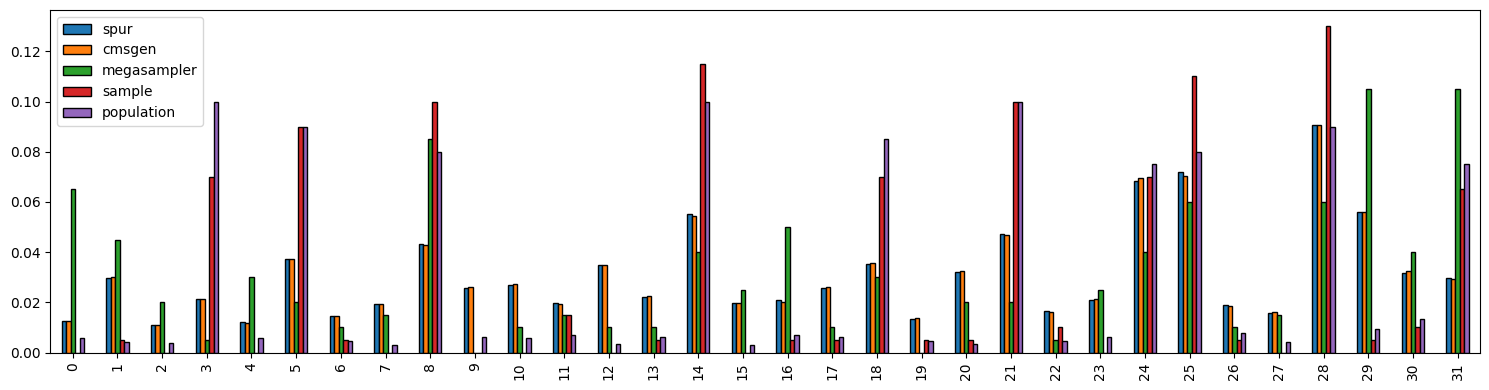

In [11]:
# zipping posterior counts with their corresponding backend
sources = [(b,p) for b,p in zip(backends,haplotypesnumber_posteriors)]
# adding counts from the sample
sources.append(('sample',haplotypesnumber))
# normalizing counts to compute haplotypes frequencies (in a frequentist manner)
normalized_sources = [(b,get_values(normalize_haplotypes_posterior(d))) for (b,d) in sources]
# adding the ground truth (haplotype frequencies used to generate genotypes)
normalized_sources.append(('population', haplotypesProb))
# put all together in a dataframe
df_p = pd.DataFrame(data=dict(normalized_sources))
# plot it!
df_p.plot.bar(figsize=(15,4), edgecolor='black');